# Setup

In [6]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pytz

In [7]:
# mount to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# define data folder within drive
data_location = "/content/drive/MyDrive/MSBA-CAPSTONE"

In [9]:
# read in all datasets so our notebook doesn't break
GA = pd.read_csv(f'{data_location}/google_analytics (2).csv')
orders = pd.read_csv(f'{data_location}/orders.csv')
sales = pd.read_csv(f'{data_location}/sales (1).csv')
visit_plan = pd.read_csv(f'{data_location}/visit_plan.csv',
                         dtype={'FREQUENCY':'string'})
customer = pd.read_csv(f'{data_location}/customer.csv')
cutoff_times = pd.read_csv(f'{data_location}/cutoff_times.csv')
operating_hours = pd.read_csv(f'{data_location}/operating_hours.csv')
material = pd.read_csv(f'{data_location}/material.csv')

# Preprocessing

Main goal: Calculate abandoned carts


### Mapping Tables



In [10]:
frequency_map = {
     '02':2, '01':1, '04':4, 'Every Second Week On':2,
     'Every Week On':1, 'Every Fourth Week On':4,
     'Every Third Week On':3, 'Every Tenth Week On':10, '03':3,
     'Every Fifth Week On':5, 'Every Eighth Week On':8,
     'Every 4 Weeks':4, 'Every Sixth Week On':6, 'Every 2 Weeks':2,
     'Every Week':1, '1 ':1, '2 ':2, '4 ':4, '3 ':3, '10':10, '05':5,
     '5 ':5, '8 ':8, '08':8, '06':6
}

sales_office_timezone_map = {
    'Glenwood Springs, CO': 'America/Denver',
    'Denver, CO': 'America/Denver',
    'Draper, UT': 'America/Denver', # Most of Utah is Mountain Time
    'Pocatello, ID': 'America/Boise', # Southern Idaho is Mountain Time
    'Tempe, AZ': 'America/Phoenix', # Arizona does not observe Daylight Saving Time
    'Scottsbluff, NE': 'America/Denver', # Western Nebraska is Mountain Time
    'Albuquerque, NM': 'America/Denver',
    'Twin Falls, ID': 'America/Boise', # Southern Idaho is Mountain Time
    'Bellevue, WA': 'America/Los_Angeles', # Pacific Time
    'Glendale, AZ': 'America/Phoenix',
    'Kingman, AZ': 'America/Phoenix',
    'Johnstown, CO': 'America/Denver',
    'Tucson, AZ': 'America/Phoenix',
    'Arlington, WA': 'America/Los_Angeles',
    'Eugene, OR': 'America/Los_Angeles', # Pacific Time
    'Ogden, UT': 'America/Denver', # Most of Utah is Mountain Time
    'Bremerton, WA': 'America/Los_Angeles',
    'Boise, ID': 'America/Boise', # Mountain Time
    'Price, UT': 'America/Denver', # Most of Utah is Mountain Time
    'Cheyenne, WY': 'America/Denver',
    'Elko, NV': 'America/Los_Angeles', # Most of Nevada is Pacific Time
    'Tacoma, WA': 'America/Los_Angeles',
    'Huachuca City, AZ': 'America/Phoenix',
    'Reno, NV': 'America/Los_Angeles', # Most of Nevada is Pacific Time
    'Wilsonville, OR': 'America/Los_Angeles',
    'Colorado Springs, CO': 'America/Denver',
    'Idaho Falls, ID': 'America/Boise', # Southern Idaho is Mountain Time
    'Spokane, WA': 'America/Los_Angeles', # Pacific Time
    'Wenatchee, WA': 'America/Los_Angeles',
    'Pendleton, OR': 'America/Los_Angeles', # Most of Oregon is Pacific Time
    'Pueblo, CO': 'America/Denver',
    'Alamosa, CO': 'America/Denver',
    'Flagstaff, AZ': 'America/Phoenix',
    'Walla Walla, WA': 'America/Los_Angeles',
    'Bend, OR': 'America/Los_Angeles', # Most of Oregon is Pacific Time
    'LaGrande, OR': 'America/Boise', # Part of Oregon is Mountain Time
    'Logan, UT': 'America/Denver', # Most of Utah is Mountain Time
    'Grand Junction, CO': 'America/Denver',
    'Richfield, UT': 'America/Denver', # Most of Utah is Mountain Time
    'Lewiston, ID': 'America/Los_Angeles', # Northern Idaho is Pacific Time
    'Prescott, AZ': 'America/Phoenix',
    'Yuma, AZ': 'America/Phoenix',
    'Show Low, AZ': 'America/Phoenix',
    'Chinle, AZ': 'America/Denver', # Navajo Nation observes Daylight Saving Time and uses Mountain Time
    np.nan: None # Handle NaN values
}

distribution_mode_map = {
    'SL': 'Sideload',
    'OF': 'OFS',
    'EZ': 'E Pallet',
    'RD': 'Rapid Delivery',
    'NR': 'Night Rapid Delivery',
    'FS': 'Full Service',
    'BK': 'Bulk Distribution',
    'SE': 'Special Events',
    'NS': 'Night Sideload',
    'NO': 'Night OFS',
    'DD': 'Direct Store Delivery',
    np.nan: None
}

shipping_conditions_map = {
    '48 Hours': '48hrs',
    '24 Hours': '24hrs',
    '72 Hours': '72hrs',
    'Dropsite 48 Hours': '48hrs',
    np.nan: None,
    'Dropsite 72 Hours': '72hrs',
    'Dropsite 24 Hours': '24hrs'
}

## Calculating Order Windows

To Calculate Order Windows, We'll first need to clean the visit plan table and calculate the exact anchor datetimes/frequencies.

Then, with this information, we'll calculate order windows

### Cleaning Visit Plan

In [11]:
# Function to combine date and time
def combine_date_time(row):
    # Check if ANCHOR_DATE is NaT
    if pd.isna(row['ANCHOR_DATE']):
        return pd.NaT # Return NaT if ANCHOR_DATE is NaT

    date = row['ANCHOR_DATE'].date()
    if pd.isnull(row['CUTOFFTIME__C']):
        time_str = '17:00:00' # 5:00 PM
    else:
        try:
            time_obj = pd.to_datetime(row['CUTOFFTIME__C']).time()
            time_str = time_obj.strftime('%H:%M:%S')
        except:
            time_str = '17:00:00' # Default to 5:00 PM

    datetime_str = f'{date} {time_str}'
    return pd.to_datetime(datetime_str)


def clean_visit_plan(visit_plan):

    # remove customers with missing important info
    # define list of customer id's to exclude
    cust_exclude = [
        600565083, 500714888, 501652104, 501653011, 500312987, 501226870, 500995978, 501654391, 501585173, 501297027, 501364983, 600581129, 501202498
    ]

    # drop these customers from the visit plan table
    visit_plan = visit_plan[~visit_plan['CUSTOMER_ID'].isin(cust_exclude)]



    # fill in missing frequency data
    # join the visit plan with the operating hours table to get our best estimate of FREQUENCY and ANCHOR_DATE
    visit_plan = visit_plan.merge(
        operating_hours,
        left_on='CUSTOMER_ID',
        right_on='CUSTOMER_NUMBER',
        how='left'
    )

    # fill the null values in FREQUENCY_x and ANCHOR_DATE with the values in FREQUENCY_y and CALLING_ANCHOR_DATE
    visit_plan['FREQUENCY_x'] = visit_plan['FREQUENCY_x'].fillna(visit_plan['FREQUENCY_y'])
    visit_plan['ANCHOR_DATE'] = visit_plan['ANCHOR_DATE'].fillna(visit_plan['CALLING_ANCHOR_DATE'])

    # rename the FREQUENCY_x column to FREQUENCY
    visit_plan = visit_plan.rename(columns={'FREQUENCY_x': 'FREQUENCY'})

    # drop the remaining columns that weren't originally in the visit plan table
    visit_plan = visit_plan.drop(columns=['CUSTOMER_NUMBER', 'FREQUENCY_y', 'DELIVERY_ANCHOR_DAY', 'CALLING_ANCHOR_DATE'])



    # map values in the frequency column to integers for calculating whether carts are abandoned.
    visit_plan['FREQUENCY'] = visit_plan['FREQUENCY'].map(frequency_map)


    # calculate Anchor datetimes in UTC

    # map the distribution mode and shipping conditions so we can join to cutoff_times
    visit_plan['DISTRIBUTION_MODE'] = visit_plan['DISTRIBUTION_MODE'].map(distribution_mode_map)
    visit_plan['SHIPPING_CONDITIONS_DESC'] = visit_plan['SHIPPING_CONDITIONS_DESC'].map(shipping_conditions_map)

    # Convert date columns to datetime, coercing errors
    visit_plan['ANCHOR_DATE'] = pd.to_datetime(visit_plan['ANCHOR_DATE'], errors='coerce')
    visit_plan['ELT_TS'] = pd.to_datetime(visit_plan['ELT_TS'], errors='coerce', utc=True) # assuming ELT_TS is in UTC
    visit_plan['SNAPSHOT_DATE'] = pd.to_datetime(visit_plan['SNAPSHOT_DATE'], errors='coerce')

    # remove snapshots that are outside of the GA time period.
    visit_plan = visit_plan[
        (visit_plan['SNAPSHOT_DATE'] >= '2024-05-31') &
        (visit_plan['SNAPSHOT_DATE'] <= '2025-05-26')]

    # Sort the visit_plan DataFrame by CUSTOMER_ID and ELT_TS and remove duplicates based on the specified columns, keeping the first occurrence
    visit_plan = visit_plan.sort_values(by=['CUSTOMER_ID', 'ELT_TS'])
    visit_plan = visit_plan.drop_duplicates(subset=['CUSTOMER_ID', 'FREQUENCY', 'ANCHOR_DATE', 'SALES_OFFICE', 'SALES_OFFICE_DESC', 'DISTRIBUTION_MODE', 'SHIPPING_CONDITIONS_DESC'], keep='first')

    # get anchor datetimes and convert to UTC

    # Perform a left join between visit_plan and cutoff_times
    visit_plan = visit_plan.merge(
        cutoff_times,
        left_on=['SALES_OFFICE_DESC', 'SHIPPING_CONDITIONS_DESC', 'DISTRIBUTION_MODE'],
        right_on=['SALES_OFFICE', 'SHIPPING_CONDITION_TIME', 'DISTRIBUTION_MODE'],
        how='left'
    )

    # Apply the function to create the new datetime column
    visit_plan['ANCHOR_DATETIME'] = visit_plan.apply(combine_date_time, axis=1)

    # Remove extra columns from cutoff_times
    visit_plan = visit_plan.drop(columns=['SALES_OFFICE_y', 'PLANT_ID', 'CUTOFFTIME__C', 'SHIPPING_CONDITION_TIME'])

    # Rename SALES_OFFICE_x to SALES OFFICE
    visit_plan = visit_plan.rename(columns={'SALES_OFFICE_x': 'SALES_OFFICE'})

    # Create TIMEZONE column by mapping SALES_OFFICE_DESC
    visit_plan['TIMEZONE'] = visit_plan['SALES_OFFICE_DESC'].map(sales_office_timezone_map)

    # Convert ANCHOR_DATETIME to UTC
    # First, localize the datetime to the respective timezone, then convert to UTC
    # Handle NaT values before timezone conversion
    visit_plan['ANCHOR_DATETIME_UTC'] = pd.NaT
    for index, row in visit_plan.iterrows():
        if pd.notna(row['ANCHOR_DATETIME']) and row['TIMEZONE']:
            try:
                local_dt = row['ANCHOR_DATETIME'].tz_localize(row['TIMEZONE'])
                visit_plan.loc[index, 'ANCHOR_DATETIME_UTC'] = local_dt.tz_convert('UTC')
            except pytz.UnknownTimeZoneError:
                # Handle cases where timezone is not recognized
                visit_plan.loc[index, 'ANCHOR_DATETIME_UTC'] = pd.NaT

    # Remove rows where ANCHOR_DATETIME_UTC is NaT
    visit_plan = visit_plan.dropna(subset=['ANCHOR_DATETIME_UTC'])

    return visit_plan

In [12]:
# test the function
visit_plan = pd.read_csv(f'{data_location}/visit_plan.csv',
                         dtype={'FREQUENCY':'string'})
visit_plan = clean_visit_plan(visit_plan)
display(visit_plan)

/tmp/ipython-input-3555368472.py:109: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2020-04-08 23:00:00+00:00' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  visit_plan.loc[index, 'ANCHOR_DATETIME_UTC'] = local_dt.tz_convert('UTC')


,CUSTOMER_ID,FREQUENCY,ELT_TS,SNAPSHOT_DATE,ANCHOR_DATE,SALES_OFFICE,SALES_OFFICE_DESC,DISTRIBUTION_MODE,SHIPPING_CONDITIONS_DESC,ANCHOR_DATETIME,TIMEZONE,ANCHOR_DATETIME_UTC
0,500245685,1,2024-06-01 01:38:22.353000+00:00,2024-05-31,2020-04-08,G111,"Draper, UT",OFS,48hrs,2020-04-08 17:00:00,America/Denver,2020-04-08 23:00:00+00:00
1,500245685,1,2024-06-01 01:38:22.353000+00:00,2024-05-31,2023-04-24,G111,"Draper, UT",OFS,48hrs,2023-04-24 17:00:00,America/Denver,2023-04-24 23:00:00+00:00
2,500245685,1,2024-06-01 01:38:22.353000+00:00,2024-05-31,2020-04-06,G111,"Draper, UT",OFS,48hrs,2020-04-06 17:00:00,America/Denver,2020-04-06 23:00:00+00:00
3,500245685,1,2024-12-16 02:40:41.679000+00:00,2024-12-15,2024-11-18,G111,"Draper, UT",OFS,48hrs,2024-11-18 17:00:00,America/Denver,2024-11-19 00:00:00+00:00
4,500245689,1,2024-06-01 01:38:22.353000+00:00,2024-05-31,2099-12-31,G111,"Draper, UT",OFS,48hrs,2099-12-31 17:00:00,America/Denver,2100-01-01 00:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
22527,600975318,1,2024-07-28 01:33:51.114000+00:00,2024-07-27,2024-07-03,G282,"Wenatchee, WA",OFS,48hrs,2024-07-03 15:30:00,America/Los_Angeles,2024-07-03 22:30:00+00:00
22528,600975318,1,2024-07-28 01:33:51.114000+00:00,2024-07-27,2024-07-01,G282,"Wenatchee, WA",OFS,48hrs,2024-07-01 15:30:00,America/Los_Angeles,2024-07-01 22:30:00+00:00
22529,600975318,1,2024-07-28 01:33:51.114000+00:00,2024-07-27,2020-10-01,G282,"Wenatchee, WA",OFS,48hrs,2020-10-01 15:30:00,America/Los_Angeles,2020-10-01 22:30:00+00:00
22530,600975318,2,2025-05-12 01:38:03.863000+00:00,2025-05-11,2025-04-14,G282,"Wenatchee, WA",OFS,48hrs,2025-04-14 15:30:00,America/Los_Angeles,2025-04-14 22:30:00+00:00


In [13]:
import pandas as pd

def filter_anchor_dates(visit_plan: pd.DataFrame) -> pd.DataFrame:
    """
    Filters `visit_plan` so that:
      1. Rows with ANCHOR_DATE between May 2024 and May 2025 (inclusive of May 1, 2024,
         exclusive of June 1, 2025) are kept.
      2. If a customer has no anchor dates in that range, keep only rows
         where that customer has their maximum ANCHOR_DATE.
    All other columns are retained.
    """

    df = visit_plan.copy()
    df["ANCHOR_DATE"] = pd.to_datetime(df["ANCHOR_DATE"], errors="coerce")

    # Define the date window
    start = pd.Timestamp("2024-05-01")
    end = pd.Timestamp("2025-06-01")

    # Step 1: mark rows in date window
    in_window = (df["ANCHOR_DATE"] >= start) & (df["ANCHOR_DATE"] < end)

    # Step 2: detect which customers have any row in that window
    # Corrected logic to use transform on the boolean Series
    has_window = df.groupby("CUSTOMER_ID")['ANCHOR_DATE'].transform(lambda x: in_window[x.index].any())


    # Step 3: keep window rows if they exist for that customer
    df_in_window = df[in_window & has_window].copy()

    # Step 4: for customers without window rows, keep only max anchor date rows
    df_no_window = df[~has_window].copy()
    max_anchor = (
        df_no_window.groupby("CUSTOMER_ID", as_index=False)["ANCHOR_DATE"].max()
        .rename(columns={"ANCHOR_DATE": "_max_anchor"})
    )

    df_no_window = df_no_window.merge(max_anchor, on="CUSTOMER_ID", how="left")
    df_no_window = df_no_window[df_no_window["ANCHOR_DATE"] == df_no_window["_max_anchor"]].copy()
    df_no_window = df_no_window.drop(columns="_max_anchor")

    # Step 5: combine results and return all original columns
    filtered = pd.concat([df_in_window, df_no_window], ignore_index=True)
    filtered = filtered.sort_values(["CUSTOMER_ID", "ANCHOR_DATE"]).reset_index(drop=True)

    return filtered

# Example usage:
visit_plan = filter_anchor_dates(visit_plan.copy())
display(visit_plan)

,CUSTOMER_ID,FREQUENCY,ELT_TS,SNAPSHOT_DATE,ANCHOR_DATE,SALES_OFFICE,SALES_OFFICE_DESC,DISTRIBUTION_MODE,SHIPPING_CONDITIONS_DESC,ANCHOR_DATETIME,TIMEZONE,ANCHOR_DATETIME_UTC
0,500245685,1,2024-12-16 02:40:41.679000+00:00,2024-12-15,2024-11-18,G111,"Draper, UT",OFS,48hrs,2024-11-18 17:00:00,America/Denver,2024-11-19 00:00:00+00:00
1,500245689,1,2024-12-15 02:37:49.606000+00:00,2024-12-14,2024-11-20,G111,"Draper, UT",OFS,48hrs,2024-11-20 17:00:00,America/Denver,2024-11-21 00:00:00+00:00
2,500245690,2,2024-12-15 02:37:49.606000+00:00,2024-12-14,2024-11-25,G111,"Draper, UT",OFS,48hrs,2024-11-25 17:00:00,America/Denver,2024-11-26 00:00:00+00:00
3,500245724,4,2024-12-15 02:37:49.606000+00:00,2024-12-14,2024-11-18,G111,"Draper, UT",OFS,48hrs,2024-11-18 17:00:00,America/Denver,2024-11-19 00:00:00+00:00
4,500245736,1,2024-12-15 02:37:49.606000+00:00,2024-12-14,2024-11-21,G111,"Draper, UT",OFS,48hrs,2024-11-21 17:00:00,America/Denver,2024-11-22 00:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
13049,600975280,4,2025-05-12 01:38:03.863000+00:00,2025-05-11,2025-04-18,G282,"Wenatchee, WA",OFS,48hrs,2025-04-18 15:30:00,America/Los_Angeles,2025-04-18 22:30:00+00:00
13050,600975318,1,2024-07-28 01:33:51.114000+00:00,2024-07-27,2024-07-01,G282,"Wenatchee, WA",OFS,48hrs,2024-07-01 15:30:00,America/Los_Angeles,2024-07-01 22:30:00+00:00
13051,600975318,1,2024-07-28 01:33:51.114000+00:00,2024-07-27,2024-07-03,G282,"Wenatchee, WA",OFS,48hrs,2024-07-03 15:30:00,America/Los_Angeles,2024-07-03 22:30:00+00:00
13052,600975318,2,2025-05-12 01:38:03.863000+00:00,2025-05-11,2025-04-14,G282,"Wenatchee, WA",OFS,48hrs,2025-04-14 15:30:00,America/Los_Angeles,2025-04-14 22:30:00+00:00


# Calculating Order Windows

To define an order window, we will use the anchor date for each customer and generate possible order windows based on their order frequency.

In [14]:
from datetime import timedelta

# adjust frequency to days
visit_plan["cycle_days"] = visit_plan["FREQUENCY"] * 7

# define function to find the possible order windows for each customer
def build_order_windows(row, start="2024-01-01", end="2025-12-31"):
    # make start and end timestamps timezone-aware (UTC)
    start = pd.Timestamp(start, tz='UTC')
    end = pd.Timestamp(end, tz='UTC')
    t = pd.Timestamp(row["ANCHOR_DATETIME_UTC"])
    cycle = pd.Timedelta(days=row["cycle_days"])

    # move forward if anchor is before the global start
    while t + cycle < start:
        t += cycle

    windows = []
    while t < end:
        windows.append({
            "CUSTOMER_ID": row["CUSTOMER_ID"],
            "window_start": t,
            "window_end": t + cycle,
            "FREQUENCY": row["FREQUENCY"],
            "ANCHOR_DATE": row["ANCHOR_DATETIME_UTC"],
            "SALES_OFFICE": row["SALES_OFFICE"],
        })
        t += cycle
    return pd.DataFrame(windows)

# this function will build every possible order window within the date range above for each visit plan
windows = pd.concat([build_order_windows(r) for _, r in visit_plan.iterrows()])
display(windows)

,CUSTOMER_ID,window_start,window_end,FREQUENCY,ANCHOR_DATE,SALES_OFFICE
0,500245685,2024-11-19 00:00:00+00:00,2024-11-26 00:00:00+00:00,1,2024-11-19 00:00:00+00:00,G111
1,500245685,2024-11-26 00:00:00+00:00,2024-12-03 00:00:00+00:00,1,2024-11-19 00:00:00+00:00,G111
2,500245685,2024-12-03 00:00:00+00:00,2024-12-10 00:00:00+00:00,1,2024-11-19 00:00:00+00:00,G111
3,500245685,2024-12-10 00:00:00+00:00,2024-12-17 00:00:00+00:00,1,2024-11-19 00:00:00+00:00,G111
4,500245685,2024-12-17 00:00:00+00:00,2024-12-24 00:00:00+00:00,1,2024-11-19 00:00:00+00:00,G111
...,...,...,...,...,...,...
14,600975318,2025-11-03 22:30:00+00:00,2025-11-17 22:30:00+00:00,2,2025-04-21 22:30:00+00:00,G282
15,600975318,2025-11-17 22:30:00+00:00,2025-12-01 22:30:00+00:00,2,2025-04-21 22:30:00+00:00,G282
16,600975318,2025-12-01 22:30:00+00:00,2025-12-15 22:30:00+00:00,2,2025-04-21 22:30:00+00:00,G282
17,600975318,2025-12-15 22:30:00+00:00,2025-12-29 22:30:00+00:00,2,2025-04-21 22:30:00+00:00,G282


Now we will use the potential order windows as a reference to define abandoned carts. For this, we only care about add to cart and purchase events, so we will filter out everything else for efficiency.

In [15]:
# to identify abandoned carts, we only care about add to cart and purchase events, filtering for those here
GA_filtered = GA[GA['EVENT_NAME'].isin(['add_to_cart', 'purchase'])].copy()

GA_filtered['EVENT_TIMESTAMP'] = pd.to_datetime(GA_filtered['EVENT_TIMESTAMP'], utc=True)

# join GA data with possible order windows
events_with_windows = pd.merge(
    GA_filtered,
    windows[["CUSTOMER_ID", "window_start", "window_end"]],
    on="CUSTOMER_ID",
    how="left"
)

# keep only events that are in the order window
in_window_mask = (
    events_with_windows["window_start"].notna()
    & (events_with_windows["EVENT_TIMESTAMP"] >= events_with_windows["window_start"])
    & (events_with_windows["EVENT_TIMESTAMP"] <  events_with_windows["window_end"])
)
events_in_windows = events_with_windows.loc[in_window_mask].copy()


# add flags for purchase events and add events
events_in_windows["is_purchase"] = (events_in_windows["EVENT_NAME"] == "purchase").astype(int)
events_in_windows["is_add"]      = (events_in_windows["EVENT_NAME"] == "add_to_cart").astype(int)

win_summary = (
    events_in_windows
      .groupby(["CUSTOMER_ID", "window_start", "window_end"], as_index=False)
      .agg(had_add=("is_add","max"),
           had_purchase=("is_purchase","max"),
           n_events=("EVENT_NAME","size"))
)

# define abandoned as a customer with an add within the window but no purchase
win_summary["Abandoned"] = ((win_summary["had_add"]==1) & (win_summary["had_purchase"]==0)).astype(int)

display(win_summary)

,CUSTOMER_ID,window_start,window_end,had_add,had_purchase,n_events,Abandoned
0,500245685,2025-02-18 00:00:00+00:00,2025-02-25 00:00:00+00:00,1,1,2,0
1,500245685,2025-03-18 00:00:00+00:00,2025-03-25 00:00:00+00:00,1,1,2,0
2,500245685,2025-04-15 00:00:00+00:00,2025-04-22 00:00:00+00:00,1,1,2,0
3,500245685,2025-04-29 00:00:00+00:00,2025-05-06 00:00:00+00:00,1,1,2,0
4,500245738,2024-07-19 21:30:00+00:00,2024-07-26 21:30:00+00:00,1,1,2,0
...,...,...,...,...,...,...,...
33572,600975276,2025-04-29 22:30:00+00:00,2025-05-13 22:30:00+00:00,1,1,12,0
33573,600975276,2025-05-02 22:30:00+00:00,2025-05-09 22:30:00+00:00,1,1,12,0
33574,600975280,2025-04-18 22:30:00+00:00,2025-05-16 22:30:00+00:00,1,1,17,0
33575,600975280,2025-04-24 22:30:00+00:00,2025-05-01 22:30:00+00:00,1,0,1,1


In [16]:
# calculate the number of abandoned carts per customer
abandoned_carts_per_customer = win_summary.groupby(['CUSTOMER_ID', 'window_start'])['Abandoned'].sum().reset_index()
abandoned_carts_per_customer = abandoned_carts_per_customer.rename(columns={'Abandoned': 'abandoned_cart_count'})
abandoned_carts_per_customer.sort_values(["abandoned_cart_count"], ascending = False).reset_index(drop=True)

,CUSTOMER_ID,window_start,abandoned_cart_count
0,501645690,2025-05-02 21:00:00+00:00,2
1,501676877,2025-02-11 00:00:00+00:00,2
2,501543383,2024-10-01 00:00:00+00:00,2
3,501293875,2025-05-17 01:00:00+00:00,2
4,500567350,2025-04-30 01:00:00+00:00,2
...,...,...,...
33016,600975210,2025-04-14 22:30:00+00:00,0
33017,600975210,2025-04-16 22:30:00+00:00,0
33018,600975210,2025-04-23 22:30:00+00:00,0
33019,500245738,2024-08-16 23:00:00+00:00,0


In [17]:
# generating simple table to flag customers with abandoned carts
customer_abandonment_summary = win_summary.groupby(['CUSTOMER_ID', 'window_start'])['Abandoned'].max().reset_index()
customer_abandonment_summary = customer_abandonment_summary.rename(columns={'Abandoned': 'had_abandoned_cart'})

In [18]:
# summary stats
total_customers = len(customer_abandonment_summary)
customers_with_abandoned_carts = customer_abandonment_summary['had_abandoned_cart'].sum()
percentage_with_abandoned_carts = (customers_with_abandoned_carts / total_customers) * 100

print(f"Total order windows: {total_customers}")
print(f"Windows with abandoned carts: {customers_with_abandoned_carts}")
print(f"Percentage of windows with abandoned carts: {percentage_with_abandoned_carts:.2f}%")

Total order windows: 33021
Windows with abandoned carts: 4850
Percentage of windows with abandoned carts: 14.69%


Overall, we see an abandonment rate of ~15% across the year within the GA data!

Now we will identify carts that were recovered before the end of their next order window.

In [19]:
import pandas as pd
import numpy as np

win = win_summary.copy()
orders2 = orders.copy()

# same datetime functions applied, can change if needed
win["window_start"] = pd.to_datetime(win["window_start"], utc=True)
win["window_end"]   = pd.to_datetime(win["window_end"], utc=True)
orders2["order_ts"] = pd.to_datetime(orders2["CREATED_DATE_UTC"], utc=True)

# keep only abandoned windows
abandoned = win.loc[win["Abandoned"] == 1].copy()

# for each abandoned window, attach the *next* order AFTER window_end (per customer)
abandoned = abandoned.sort_values(["window_end"]).reset_index(drop=True)
orders2   = orders2.sort_values(["order_ts"]).reset_index(drop=True)

# use forward asof to get the first order at/after window_end
next_order = pd.merge_asof(
    abandoned,
    orders2,
    left_on="window_end",
    right_on="order_ts",
    by="CUSTOMER_ID",
    direction="forward",
    allow_exact_matches=False,  # use True if you consider an order exactly at window_end as "after"
)

# looking to see if there was a purchase in the next window
win_sorted = win.sort_values(["CUSTOMER_ID","window_end"], kind="mergesort")
win_sorted["next_window_end"] = (
    win_sorted.groupby("CUSTOMER_ID")["window_end"].shift(-1)
)

# merge in the next_window_end for the same abandoned row
next_order = next_order.merge(
    win_sorted[["CUSTOMER_ID","window_end","next_window_end"]],
    on=["CUSTOMER_ID","window_end"],
    how="left"
)

next_order["Recovered_before_next_window_end"] = (
    next_order["order_ts"].notna()
    & next_order["next_window_end"].notna()
    & (next_order["order_ts"] < next_order["next_window_end"])
).astype(int)

next_order["time_to_recovery_days"] = np.where(
    next_order["order_ts"].notna(),
    (next_order["order_ts"] - next_order["window_end"]) / np.timedelta64(1, "D"),
    np.nan
)

# label columns
recovery_cols = [
    "CUSTOMER_ID","window_start","window_end","order_ts", "Recovered_before_next_window_end",
    "time_to_recovery_days"
]
recovered_flags = next_order[recovery_cols]

win_with_recovery = win.merge(
    recovered_flags,
    on=["CUSTOMER_ID","window_start","window_end"],
    how="left"
)

for col in ["Recovered_before_next_window_end"]:
    win_with_recovery[col] = win_with_recovery[col].fillna(0).astype(int)

display(win_with_recovery)

,CUSTOMER_ID,window_start,window_end,had_add,had_purchase,n_events,Abandoned,order_ts,Recovered_before_next_window_end,time_to_recovery_days
0,500245685,2025-02-18 00:00:00+00:00,2025-02-25 00:00:00+00:00,1,1,2,0,NaT,0,NaN
1,500245685,2025-03-18 00:00:00+00:00,2025-03-25 00:00:00+00:00,1,1,2,0,NaT,0,NaN
2,500245685,2025-04-15 00:00:00+00:00,2025-04-22 00:00:00+00:00,1,1,2,0,NaT,0,NaN
3,500245685,2025-04-29 00:00:00+00:00,2025-05-06 00:00:00+00:00,1,1,2,0,NaT,0,NaN
4,500245738,2024-07-19 21:30:00+00:00,2024-07-26 21:30:00+00:00,1,1,2,0,NaT,0,NaN
...,...,...,...,...,...,...,...,...,...,...
33714,600975276,2025-04-29 22:30:00+00:00,2025-05-13 22:30:00+00:00,1,1,12,0,NaT,0,NaN
33715,600975276,2025-05-02 22:30:00+00:00,2025-05-09 22:30:00+00:00,1,1,12,0,NaT,0,NaN
33716,600975280,2025-04-18 22:30:00+00:00,2025-05-16 22:30:00+00:00,1,1,17,0,NaT,0,NaN
33717,600975280,2025-04-24 22:30:00+00:00,2025-05-01 22:30:00+00:00,1,0,1,1,2025-05-06 22:50:17+00:00,1,5.014086


In [20]:
# filter win_with_recovery to include only abandoned windows
abandoned_windows_with_recovery_info = win_with_recovery[win_with_recovery['Abandoned'] == 1].copy()

# calculate the number of abandoned windows that were recovered
recovered_abandoned_windows_count = abandoned_windows_with_recovery_info['Recovered_before_next_window_end'].sum()

# calculate the total number of abandoned windows
total_abandoned_windows_count = abandoned_windows_with_recovery_info.shape[0]

# calculate the recovery rate
recovery_rate = (recovered_abandoned_windows_count / total_abandoned_windows_count) * 100 if total_abandoned_windows_count > 0 else 0

print(f"Total abandoned windows: {total_abandoned_windows_count}")
print(f"Abandoned windows recovered before the end of the next window: {recovered_abandoned_windows_count}")
print(f"Recovery rate of abandoned carts: {recovery_rate:.2f}%")

Total abandoned windows: 5045
Abandoned windows recovered before the end of the next window: 2362
Recovery rate of abandoned carts: 46.82%


We see a fairly high recovery rate among abandoned carts!

# Analyzing financial impact of abandoned carts

Now that we have defined abandoned and recovered carts, we will not analyze the financial impact of abandoned carts.

In [21]:
# load the full_events_in_windows dataset
full_events_in_windows = pd.read_csv(f'{data_location}/full_events_in_windows.csv')

In [22]:
# convert date colums to datetime with UTC
full_events_in_windows['window_start'] = pd.to_datetime(full_events_in_windows['window_start'], utc=True)
full_events_in_windows['window_end'] = pd.to_datetime(full_events_in_windows['window_end'], utc=True)

win_with_recovery['window_start'] = pd.to_datetime(win_with_recovery['window_start'], utc=True)
win_with_recovery['window_end'] = pd.to_datetime(win_with_recovery['window_end'], utc=True)


# join full_events_in_windows with win_with_recovery to get the Abandoned and Recovered flags
full_events_with_flags = pd.merge(
    full_events_in_windows,
    win_with_recovery[['CUSTOMER_ID', 'window_start', 'window_end', 'Abandoned', 'Recovered_before_next_window_end']],
    on=['CUSTOMER_ID', 'window_start', 'window_end'],
    how='left'
)

display(full_events_with_flags)

,CUSTOMER_ID,EVENT_DATE,EVENT_TIMESTAMP,EVENT_NAME,DEVICE_CATEGORY,DEVICE_MOBILE_BRAND_NAME,DEVICE_OPERATING_SYSTEM,EVENT_PAGE_NAME,EVENT_PAGE_TITLE,ITEMS,window_start,window_end,Abandoned,Recovered_before_next_window_end
0,501508595,2025-04-07,2025-04-07 14:57:40.713000+00:00,view_search_results,mobile,Samsung,Android,Product List,NaN,[],2025-04-02 22:00:00+00:00,2025-04-09 22:00:00+00:00,0.0,0.0
1,501730915,2025-04-07,2025-04-07 19:28:54.546000+00:00,view_item_list,desktop,Google,Windows,NaN,Search,"[{""item_id"":""158520"",""quantity"":""1""},{""item_id...",2025-04-01 21:00:00+00:00,2025-04-08 21:00:00+00:00,0.0,0.0
2,501730915,2025-04-07,2025-04-07 19:28:54.546000+00:00,view_item_list,desktop,Google,Windows,NaN,Search,"[{""item_id"":""158520"",""quantity"":""1""},{""item_id...",2025-04-01 21:00:00+00:00,2025-04-08 21:00:00+00:00,0.0,0.0
3,501730915,2025-04-07,2025-04-07 19:28:54.546000+00:00,view_item_list,desktop,Google,Windows,NaN,Search,"[{""item_id"":""158520"",""quantity"":""1""},{""item_id...",2025-04-03 21:00:00+00:00,2025-04-10 21:00:00+00:00,0.0,0.0
4,501730915,2025-04-07,2025-04-07 19:28:54.546000+00:00,view_item_list,desktop,Google,Windows,NaN,Search,"[{""item_id"":""158520"",""quantity"":""1""},{""item_id...",2025-04-03 21:00:00+00:00,2025-04-10 21:00:00+00:00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4919465,501652046,2024-06-20,2024-06-20 16:41:32.073000+00:00,page_view,mobile,Apple,iOS,NaN,myWallet,[],2024-06-18 00:00:00+00:00,2024-07-02 00:00:00+00:00,NaN,NaN
4919466,501652046,2024-06-20,2024-06-20 16:41:32.073000+00:00,page_view,mobile,Apple,iOS,NaN,myWallet,[],2024-06-20 00:00:00+00:00,2024-07-04 00:00:00+00:00,NaN,NaN
4919467,501652046,2024-06-20,2024-06-20 16:41:32.073000+00:00,page_view,mobile,Apple,iOS,NaN,myWallet,[],2024-06-20 00:00:00+00:00,2024-07-04 00:00:00+00:00,NaN,NaN
4919468,600054564,2025-03-22,2025-03-22 21:31:57.667000+00:00,view_item_list,desktop,Microsoft,Windows,MyCoke Orders,Category: All Products,[],2025-03-20 00:00:00+00:00,2025-03-27 00:00:00+00:00,0.0,0.0


The data does not include a cart column, the following code will build a customer's cart based on their add to cart and remove from cart events.

In [23]:
import json
from collections import defaultdict

def simulate_cart_and_get_abandoned_items(events_in_windows):
    """
    Simulates the cart state for each customer within each window
    and returns a DataFrame with abandoned items for windows with no purchase.
    """
    abandoned_items_list = []

    # group events by customer and window
    grouped_events = events_in_windows.sort_values('EVENT_TIMESTAMP').groupby(['CUSTOMER_ID', 'window_start', 'window_end'])

    for (customer_id, window_start, window_end), events in grouped_events:
        cart = defaultdict(int)
        had_purchase = False

        for _, event in events.iterrows():
            event_name = event['EVENT_NAME']
            items = event['ITEMS']

            if pd.notna(items):
                try:
                    items_list = json.loads(items)
                    for item in items_list:
                        item_id = item.get('item_id')
                        quantity = int(item.get('quantity', 0))

                        if item_id:
                            if event_name == 'add_to_cart':
                                cart[item_id] += quantity
                            elif event_name == 'remove_from_cart':
                                cart[item_id] = max(0, cart[item_id] - quantity) # ensure quantity doesn't go below zero
                            elif event_name == 'purchase':
                                had_purchase = True
                                cart = defaultdict(int) # reset cart on purchase
                                break

                except json.JSONDecodeError:
                    # handle cases where 'ITEMS' is not a valid JSON string
                    continue

        # after processing all events in the window, check if it was abandoned
        if not had_purchase and len(cart) > 0:
             # filter out items with zero quantity
            abandoned_items = {item_id: quantity for item_id, quantity in cart.items() if quantity > 0}
            if abandoned_items:
                abandoned_items_list.append({
                    'CUSTOMER_ID': customer_id,
                    'window_start': window_start,
                    'window_end': window_end,
                    'abandoned_items': abandoned_items
                })

    return pd.DataFrame(abandoned_items_list)

Let's apply the function to abandoned carts to get their items.

In [24]:
# filter for abandoned windows
abandoned_events_with_flags = full_events_with_flags[full_events_with_flags['Abandoned'] == 1].copy()

# get abandoned items for the abandoned windows
abandoned_items_per_window = simulate_cart_and_get_abandoned_items(abandoned_events_with_flags)

display(abandoned_items_per_window)

,CUSTOMER_ID,window_start,window_end,abandoned_items
0,500245738,2024-11-08 21:30:00+00:00,2024-11-15 21:30:00+00:00,"{'157298': 1, '117854': 5, '117603': 5, '15608..."
1,500245738,2024-11-08 23:00:00+00:00,2024-11-15 23:00:00+00:00,"{'157298': 1, '117854': 5, '117603': 5, '15608..."
2,500245738,2025-01-30 00:00:00+00:00,2025-02-06 00:00:00+00:00,"{'158489': 1, '156082': 1, '151817': 3, '15329..."
3,500245738,2025-01-31 21:30:00+00:00,2025-02-07 21:30:00+00:00,"{'158489': 1, '156082': 1, '151817': 3, '15329..."
4,500245738,2025-01-31 23:00:00+00:00,2025-02-07 23:00:00+00:00,"{'158489': 1, '156082': 1, '151817': 3, '15329..."
...,...,...,...,...
4506,600866904,2024-11-08 00:00:00+00:00,2024-11-15 00:00:00+00:00,"{'103889': 2, '112259': 12, '103886': 2}"
4507,600866904,2024-11-12 00:00:00+00:00,2024-11-19 00:00:00+00:00,"{'103889': 2, '112259': 12, '103886': 2}"
4508,600975210,2024-11-13 22:30:00+00:00,2024-11-20 22:30:00+00:00,"{'412024': 1, '411040': 1, '110802': 1}"
4509,600975210,2025-02-26 22:30:00+00:00,2025-03-05 22:30:00+00:00,"{'145105': 1, '133129': 1, '103888': 1}"


Now that we have the items, we will attach a profit amount to each material id. Because there is no explicit profit per item column we will calculate one using the average profit per unit from the sales table.

In [25]:
# calculate profit per unit
sales['profit_per_unit'] = sales['GROSS_PROFIT_DEAD_NET'] / sales['PHYSICAL_VOLUME']

# calculate the average profit per unit for each item
average_profit_per_item = sales.groupby('MATERIAL_ID')['profit_per_unit'].mean().reset_index()

# rename the column for clarity
average_profit_per_item = average_profit_per_item.rename(columns={'profit_per_unit': 'average_profit_per_unit'})

display(average_profit_per_item)

,MATERIAL_ID,average_profit_per_unit
0,100722,7.719879
1,100724,8.868830
2,101728,13.693392
3,101891,18.425048
4,101969,12.467675
...,...,...
956,700434,80.931068
957,700435,65.395000
958,700436,92.332857
959,700453,52.090000


In [26]:
# join the sales and material tables on MATERIAL_ID
sales_with_material = sales.merge(material, on='MATERIAL_ID', how='left')

display(sales_with_material.head())

,CUSTOMER_ID,POSTING_DATE,MATERIAL_ID,GROSS_PROFIT_DEAD_NET,PHYSICAL_VOLUME,NSI_DEAD_NET,profit_per_unit,PACK_TYPE_DESC,TRADE_MARK_DESC,FLAVOUR_DESC,PACK_SIZE_DESC,BEV_CAT_DESC
0,600055574,7/17/2024,144775,130.68,22.0,737.00,5.940000,Aluminum Can,Bobby's Bottles,Matcha,16 OZ,ENERGY DRINKS
1,600055574,7/17/2024,156082,37.42,6.0,105.42,6.236667,Plastic Bottle - Other,Pete's Popcorn,Dragonfruit,20 OZ,ENHANCED WATER BEVERAGES
2,501438989,7/17/2024,144775,41.84,4.0,166.40,10.460000,Aluminum Can,Bobby's Bottles,Matcha,16 OZ,ENERGY DRINKS
3,600055574,7/17/2024,154914,53.24,4.0,123.88,13.310000,Plastic Bottle - Other,Sam's,Raspberry Lime,12 OZ,JUICES/NECTARS
4,600055574,7/17/2024,156182,110.30,10.0,348.80,11.030000,Plastic Bottle - Other,Fizz Factory,Grape,14 OZ,DAIRY/SOY BEVERAGES


Now that we have a financial value for each item, we can calculate the financial impact of items in abandoned carts.

In [27]:
import json
from collections import defaultdict
import pandas as pd

# filter for abandoned windows
abandoned_events_with_flags = full_events_with_flags[full_events_with_flags['Abandoned'] == 1].copy()

# get items for abandoned carts
abandoned_items_per_window = simulate_cart_and_get_abandoned_items(abandoned_events_with_flags)


# expand the 'abandoned_items' dictionary into separate rows
expanded_data = []
for index, row in abandoned_items_per_window.iterrows():
    customer_id = row['CUSTOMER_ID']
    window_start = row['window_start']
    window_end = row['window_end']
    abandoned_items = row['abandoned_items']

    for item_id, quantity in abandoned_items.items():
        expanded_data.append({
            'CUSTOMER_ID': customer_id,
            'window_start': window_start,
            'window_end': window_end,
            'MATERIAL_ID': item_id,
            'abandoned_quantity': quantity
        })

abandoned_items_expanded = pd.DataFrame(expanded_data)

abandoned_items_expanded['MATERIAL_ID'] = pd.to_numeric(abandoned_items_expanded['MATERIAL_ID'], errors='coerce')

# drop rows where MATERIAL_ID is NaN after conversion
abandoned_items_expanded.dropna(subset=['MATERIAL_ID'], inplace=True)

# convert MATERIAL_ID in average_profit_per_item to int for merging
average_profit_per_item['MATERIAL_ID'] = average_profit_per_item['MATERIAL_ID'].astype(int)
abandoned_items_expanded['MATERIAL_ID'] = abandoned_items_expanded['MATERIAL_ID'].astype(int)

# convert MATERIAL_ID in material to int for merging
material['MATERIAL_ID'] = material['MATERIAL_ID'].astype(int)

# join with average profit per item to estimate potential loss per item instance
abandoned_items_with_profit = pd.merge(
    abandoned_items_expanded,
    average_profit_per_item,
    on='MATERIAL_ID',
    how='left'
)

# calculate potential financial loss per abandoned item instance
abandoned_items_with_profit['potential_financial_loss'] = (
    abandoned_items_with_profit['abandoned_quantity'] * abandoned_items_with_profit['average_profit_per_unit']
)

# join with material data for product mix analysis
abandoned_items_with_details = pd.merge(
    abandoned_items_with_profit,
    material,
    on='MATERIAL_ID',
    how='left'
)

In [28]:
# calculate total estimated revenue lost from abandoned carts
total_estimated_loss = abandoned_items_with_details['potential_financial_loss'].sum()
print(f"Total estimated financial loss from abandoned carts: ${total_estimated_loss:,.2f}")

total_revenue = sales['GROSS_PROFIT_DEAD_NET'].sum()
print(f"\nTotal revenue from sales (Gross Profit): ${total_revenue:,.2f}")

# calculate percentage of estimated loss compared to total revenue
percentage_loss_of_revenue = (total_estimated_loss / total_revenue) * 100 if total_revenue > 0 else 0
print(f"\nEstimated financial loss as a percentage of total revenue (Gross Profit): {percentage_loss_of_revenue:.2f}%")

Total estimated financial loss from abandoned carts: $2,897,875.70

Total revenue from sales (Gross Profit): $35,613,850.43

Estimated financial loss as a percentage of total revenue (Gross Profit): 8.14%


In [29]:
# analyze product mix of abandoned items by brand and pack type
abandoned_product_mix_brand = abandoned_items_with_details.groupby('TRADE_MARK_DESC')['potential_financial_loss'].sum().sort_values(ascending=False).reset_index()
abandoned_product_mix_pack_type = abandoned_items_with_details.groupby('PACK_TYPE_DESC')['potential_financial_loss'].sum().sort_values(ascending=False).reset_index()

print("\nEstimated financial loss from abandoned carts by Brand:")
abandoned_product_mix_brand['potential_financial_loss'] = abandoned_product_mix_brand['potential_financial_loss'].map('${:,.2f}'.format)
display(abandoned_product_mix_brand)

print("\nEstimated financial loss from abandoned carts by Pack Type:")
abandoned_product_mix_pack_type['potential_financial_loss'] = abandoned_product_mix_pack_type['potential_financial_loss'].map('${:,.2f}'.format)
display(abandoned_product_mix_pack_type)


Estimated financial loss from abandoned carts by Brand:


,TRADE_MARK_DESC,potential_financial_loss
0,Oliver Originals,"$1,113,502.28"
1,Fizz Factory,"$668,252.61"
2,Pete's Popcorn,"$251,367.00"
3,Jack's Juices,"$215,904.72"
4,Sam's,"$183,174.26"
5,Grandma's Pantry,"$125,544.09"
6,Blueberry Hill,"$92,776.37"
7,Lucy & Co.,"$74,511.31"
8,Billy's Lemonade,"$67,460.51"
9,Bobby's Bottles,"$41,561.71"



Estimated financial loss from abandoned carts by Pack Type:


,PACK_TYPE_DESC,potential_financial_loss
0,Plastic Bottle - Other,"$967,349.49"
1,Plastic Bottle - Contour,"$818,639.05"
2,Aluminum Can,"$514,852.07"
3,Bag-In-Box,"$222,131.20"
4,Plastic Bottle - Dimple,"$122,542.01"
5,Glass Bottle - Contour,"$97,973.24"
6,Aluminum Can - SLIIM,"$47,598.78"
7,CO2 Tank,"$40,308.54"
8,Glass Bottle - Other,"$25,315.58"
9,Paper Cup,"$20,188.10"


From our analysis, we see that abandoned carts account for almost $3 million in lost revenue. Being able to predict abandonment will be essential is recovering this lost revenue!

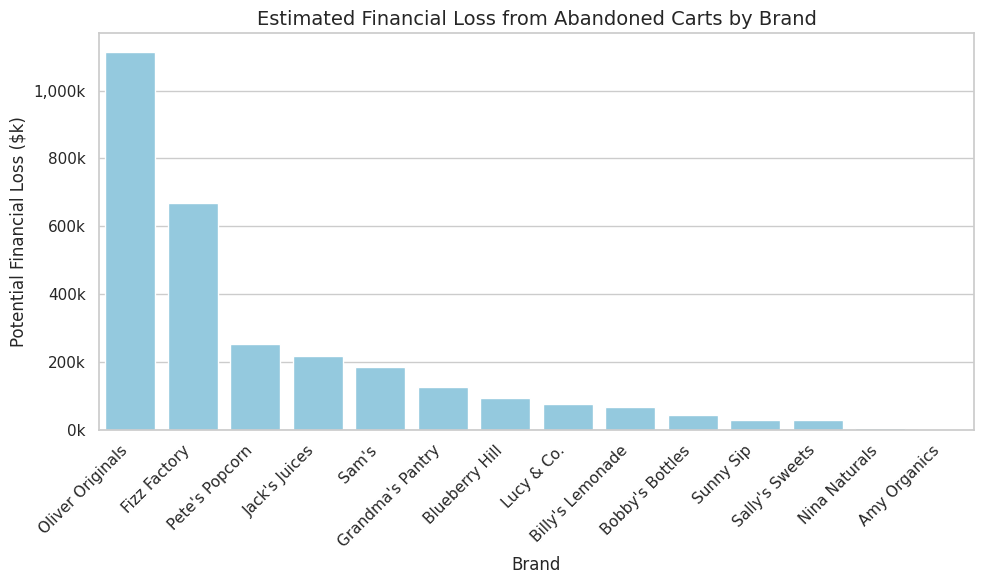

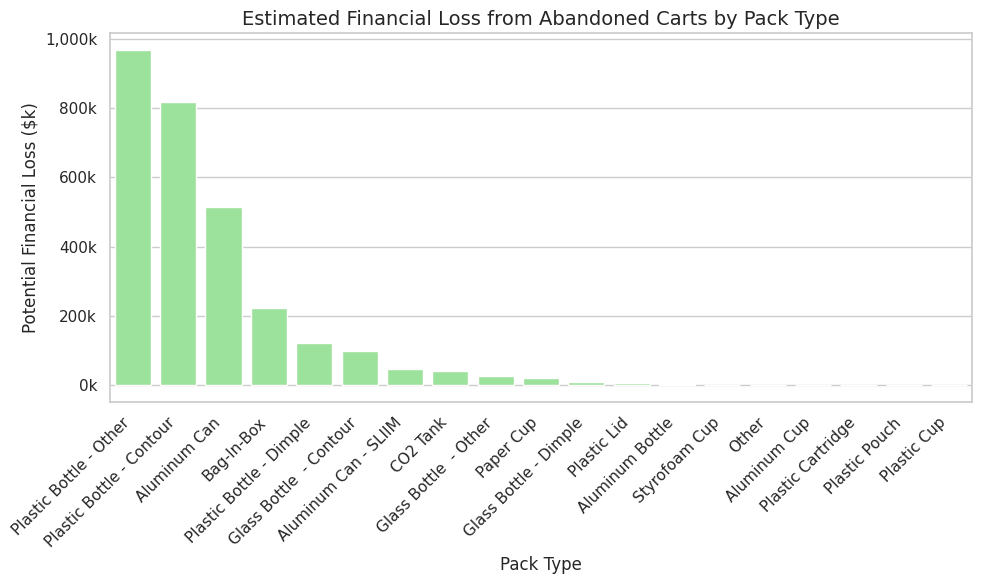

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# Set style
sns.set(style="whitegrid")

# Bar chart: Financial loss by Brand
abandoned_product_mix_brand_plot = (
    abandoned_items_with_details.groupby('TRADE_MARK_DESC')['potential_financial_loss']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=abandoned_product_mix_brand_plot,
    x='TRADE_MARK_DESC',
    y='potential_financial_loss',
    color='skyblue',
    order=abandoned_product_mix_brand_plot['TRADE_MARK_DESC']  # preserve descending order
)
plt.title('Estimated Financial Loss from Abandoned Carts by Brand', fontsize=14)
plt.xlabel('Brand', fontsize=12)
plt.ylabel('Potential Financial Loss ($k)', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Format y-axis in thousands
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x/1000):,}k'))

plt.tight_layout()
plt.show()


# Bar chart: Financial loss by Pack Type
abandoned_product_mix_pack_type_plot = (
    abandoned_items_with_details.groupby('PACK_TYPE_DESC')['potential_financial_loss']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=abandoned_product_mix_pack_type_plot,
    x='PACK_TYPE_DESC',
    y='potential_financial_loss',
    color='lightgreen',
    order=abandoned_product_mix_pack_type_plot['PACK_TYPE_DESC']  # keep descending order
)
plt.title('Estimated Financial Loss from Abandoned Carts by Pack Type', fontsize=14)
plt.xlabel('Pack Type', fontsize=12)
plt.ylabel('Potential Financial Loss ($k)', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Format y-axis in thousands
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x/1000):,}k'))

plt.tight_layout()
plt.show()

## Cart abandonment per device type

Now we will analyze abandonment by device type and try to identify friction points across the devices.




In [31]:
# add flags for purchase events and add events
full_events_with_flags["is_purchase"] = (full_events_with_flags["EVENT_NAME"] == "purchase").astype(int)
full_events_with_flags["is_add"] = (full_events_with_flags["EVENT_NAME"] == "add_to_cart").astype(int)

# group the data by customer, window, and device category, then aggregate to get the max 'is_add' and 'is_purchase' for each window and device
device_window_summary = full_events_with_flags.groupby(['CUSTOMER_ID', 'window_start', 'window_end', 'DEVICE_CATEGORY','DEVICE_MOBILE_BRAND_NAME', 'DEVICE_OPERATING_SYSTEM']).agg(
    had_add=('is_add', 'max'),
    had_purchase=('is_purchase', 'max')
).reset_index()

# define abandoned as a customer with an add within the window but no purchase
device_window_summary["Abandoned"] = ((device_window_summary["had_add"] == 1) & (device_window_summary["had_purchase"] == 0)).astype(int)

display(device_window_summary.head())

,CUSTOMER_ID,window_start,window_end,DEVICE_CATEGORY,DEVICE_MOBILE_BRAND_NAME,DEVICE_OPERATING_SYSTEM,had_add,had_purchase,Abandoned
0,500245685,2024-12-24 00:00:00+00:00,2024-12-31 00:00:00+00:00,desktop,Google,Windows,0,0,0
1,500245685,2024-12-31 00:00:00+00:00,2025-01-07 00:00:00+00:00,desktop,Google,Windows,0,0,0
2,500245685,2025-01-07 00:00:00+00:00,2025-01-14 00:00:00+00:00,desktop,Google,Windows,0,0,0
3,500245685,2025-01-28 00:00:00+00:00,2025-02-04 00:00:00+00:00,desktop,Google,Windows,0,0,0
4,500245685,2025-02-18 00:00:00+00:00,2025-02-25 00:00:00+00:00,desktop,Google,Windows,1,1,0


In [32]:
# group by DEVICE_CATEGORY and calculate the sum of Abandoned and had_add
abandonment_by_device = device_window_summary.groupby('DEVICE_CATEGORY').agg(
    total_windows_with_add=('had_add', 'sum'),
    abandoned_windows=('Abandoned', 'sum')
).reset_index()

# calculate the abandonment rate
abandonment_by_device['abandonment_rate'] = np.where(
    abandonment_by_device['total_windows_with_add'] > 0,
    (abandonment_by_device['abandoned_windows'] / abandonment_by_device['total_windows_with_add']) * 100,
    0
)

display(abandonment_by_device)

,DEVICE_CATEGORY,total_windows_with_add,abandoned_windows,abandonment_rate
0,desktop,26170,4324,16.522736
1,mobile,5219,1266,24.257521
2,tablet,346,84,24.277457


We see higher rates of abandonedment in mobile and tablet orders, implying that there are potential friction points in the checkout process for those devices. Let's look at the event patterns in abandoned carts across the device types to try an idetify more detailed friction points.

In [33]:
# filter for abandoned windows
abandoned_windows_events = full_events_with_flags[full_events_with_flags['Abandoned'] == 1].copy()

# group by device category and event name and count occurrences
event_counts_by_device = abandoned_windows_events.groupby(['DEVICE_CATEGORY', 'EVENT_NAME']).size().reset_index(name='event_count')

# sort the results to see the most common events for each device
event_counts_by_device = event_counts_by_device.sort_values(['DEVICE_CATEGORY', 'event_count'], ascending=[True, False])

display(event_counts_by_device)

,DEVICE_CATEGORY,EVENT_NAME,event_count
8,desktop,page_view,145158
2,desktop,button_click,110641
20,desktop,view_item_list,101425
0,desktop,add_to_cart,31212
18,desktop,update_cart,28260
...,...,...,...
202,tablet,select_promotion,4
191,tablet,first_visit,3
143,tablet,Close_Profile_Clicked,2
184,tablet,add_shipping_info,1


The event names are very granular, let's look at event page name and title instead for more general analysis.



In [34]:
# filter the DataFrame to include only rows where the Abandoned column is equal to 1
abandoned_events_with_flags = full_events_with_flags[full_events_with_flags['Abandoned'] == 1].copy()

# group by DEVICE_CATEGORY and EVENT_PAGE_NAME, count occurrences, and sort
page_name_counts = abandoned_events_with_flags.groupby(['DEVICE_CATEGORY', 'EVENT_PAGE_NAME']).size().reset_index(name='page_name_count')
page_name_counts = page_name_counts.sort_values(['DEVICE_CATEGORY', 'page_name_count'], ascending=[True, False])

# group by DEVICE_CATEGORY and EVENT_PAGE_TITLE, count occurrences, and sort
page_title_counts = abandoned_events_with_flags.groupby(['DEVICE_CATEGORY', 'EVENT_PAGE_TITLE']).size().reset_index(name='page_title_count')
page_title_counts = page_title_counts.sort_values(['DEVICE_CATEGORY', 'page_title_count'], ascending=[True, False])

print("Top page names in abandoned windows by device category:")
for device in page_name_counts['DEVICE_CATEGORY'].unique():
    print(f"\nDevice Category: {device}")
    display(page_name_counts[page_name_counts['DEVICE_CATEGORY'] == device].head())

print("\nTop page titles in abandoned windows by device category:")
for device in page_title_counts['DEVICE_CATEGORY'].unique():
    print(f"\nDevice Category: {device}")
    display(page_title_counts[page_title_counts['DEVICE_CATEGORY'] == device].head())

Top page names in abandoned windows by device category:

Device Category: desktop


,DEVICE_CATEGORY,EVENT_PAGE_NAME,page_name_count
8,desktop,MyCoke Orders,149136
9,desktop,MyCoke Orders - Cart,84313
4,desktop,MyCoke Dashboard,60902
11,desktop,MyCoke Orders - Product:,53777
10,desktop,MyCoke Orders - Checkout: Review Order,8568



Device Category: mobile


,DEVICE_CATEGORY,EVENT_PAGE_NAME,page_name_count
31,mobile,MyCoke Orders,19246
32,mobile,MyCoke Orders - Cart,13762
27,mobile,MyCoke Dashboard,9549
41,mobile,Product List,6645
34,mobile,MyCoke Orders - Product:,4071



Device Category: tablet


,DEVICE_CATEGORY,EVENT_PAGE_NAME,page_name_count
56,tablet,MyCoke Orders,1800
57,tablet,MyCoke Orders - Cart,819
65,tablet,Product List,776
59,tablet,MyCoke Orders - Product:,582
52,tablet,MyCoke Dashboard,515



Top page titles in abandoned windows by device category:

Device Category: desktop


,DEVICE_CATEGORY,EVENT_PAGE_TITLE,page_title_count
6,desktop,Category: All Products,96059
4,desktop,Cart,61089
570,desktop,Search,60650
48,desktop,Home,58088
24,desktop,Category: Sparkling Soft Drinks,24121



Device Category: mobile


,DEVICE_CATEGORY,EVENT_PAGE_TITLE,page_title_count
625,mobile,Category: All Products,18377
782,mobile,Search,11610
623,mobile,Cart,10368
657,mobile,Home,8666
624,mobile,Category,2091



Device Category: tablet


,DEVICE_CATEGORY,EVENT_PAGE_TITLE,page_title_count
812,tablet,Category: All Products,743
810,tablet,Cart,525
834,tablet,Home,509
825,tablet,Category: Sparkling Soft Drinks,464
863,tablet,Search,322


We notice that MyCoke Orders' and pages without specific names/titles are common, potentially indicating navigation issues or unexpected redirects. Also, high search activity ('Search' page title) in abandoned sessions could point to difficulties finding desired products. Lastly, higher abandonment rate on tablet and mobile suggests potential tablet or mobile-specific usability issues in the checkout process.

# Understanding Abandonment and Recovery in Relation to Cutoff Windows

In [35]:
# Read in full_events_in_windows.csv
full_events_in_windows = pd.read_csv(f'{data_location}/full_events_in_windows.csv')

In [36]:
# Inspecting dataset
full_events_in_windows.head()

,CUSTOMER_ID,EVENT_DATE,EVENT_TIMESTAMP,EVENT_NAME,DEVICE_CATEGORY,DEVICE_MOBILE_BRAND_NAME,DEVICE_OPERATING_SYSTEM,EVENT_PAGE_NAME,EVENT_PAGE_TITLE,ITEMS,window_start,window_end
0,501508595,2025-04-07,2025-04-07 14:57:40.713000+00:00,view_search_results,mobile,Samsung,Android,Product List,NaN,[],2025-04-02 22:00:00+00:00,2025-04-09 22:00:00+00:00
1,501730915,2025-04-07,2025-04-07 19:28:54.546000+00:00,view_item_list,desktop,Google,Windows,NaN,Search,"[{""item_id"":""158520"",""quantity"":""1""},{""item_id...",2025-04-01 21:00:00+00:00,2025-04-08 21:00:00+00:00
2,501730915,2025-04-07,2025-04-07 19:28:54.546000+00:00,view_item_list,desktop,Google,Windows,NaN,Search,"[{""item_id"":""158520"",""quantity"":""1""},{""item_id...",2025-04-01 21:00:00+00:00,2025-04-08 21:00:00+00:00
3,501730915,2025-04-07,2025-04-07 19:28:54.546000+00:00,view_item_list,desktop,Google,Windows,NaN,Search,"[{""item_id"":""158520"",""quantity"":""1""},{""item_id...",2025-04-03 21:00:00+00:00,2025-04-10 21:00:00+00:00
4,501730915,2025-04-07,2025-04-07 19:28:54.546000+00:00,view_item_list,desktop,Google,Windows,NaN,Search,"[{""item_id"":""158520"",""quantity"":""1""},{""item_id...",2025-04-03 21:00:00+00:00,2025-04-10 21:00:00+00:00


In [37]:
# Inspect Win with recovery data
win_with_recovery.head()

,CUSTOMER_ID,window_start,window_end,had_add,had_purchase,n_events,Abandoned,order_ts,Recovered_before_next_window_end,time_to_recovery_days
0,500245685,2025-02-18 00:00:00+00:00,2025-02-25 00:00:00+00:00,1,1,2,0,NaT,0,NaN
1,500245685,2025-03-18 00:00:00+00:00,2025-03-25 00:00:00+00:00,1,1,2,0,NaT,0,NaN
2,500245685,2025-04-15 00:00:00+00:00,2025-04-22 00:00:00+00:00,1,1,2,0,NaT,0,NaN
3,500245685,2025-04-29 00:00:00+00:00,2025-05-06 00:00:00+00:00,1,1,2,0,NaT,0,NaN
4,500245738,2024-07-19 21:30:00+00:00,2024-07-26 21:30:00+00:00,1,1,2,0,NaT,0,NaN


In [38]:
# How far from the cutoff window did people purchase
win_with_recovery['purchase_gap_from_window_end'] = (win_with_recovery['order_ts'] - win_with_recovery['window_end']).dt.total_seconds() / 86400
win_with_recovery['purchase_gap_from_window_end'].describe()

,purchase_gap_from_window_end
count,3802.000000
mean,14.379675
std,21.632620
min,0.000567
25%,2.958568
50%,6.917153
75%,16.844034
max,220.954606


Text(0, 0.5, 'Number of customers')

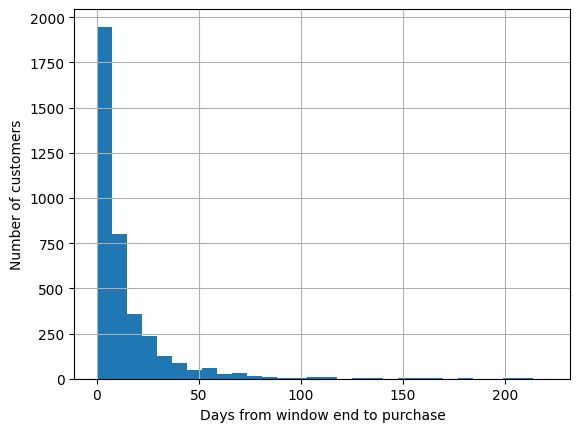

In [39]:
# Visualize with a histogram
import matplotlib.pyplot as plt
win_with_recovery['purchase_gap_from_window_end'].hist(bins=30)
plt.xlabel('Days from window end to purchase')
plt.ylabel('Number of customers')

In [40]:
# Count how much activity happens before the window ends and which specific activity type happens the most in that period

# Count total events per customer
activity_counts = full_events_in_windows.groupby('CUSTOMER_ID')['EVENT_TIMESTAMP'].count().reset_index(name='n_events_total')


In [41]:
# Find each customer's last event timestamp
last_events = full_events_in_windows.groupby('CUSTOMER_ID')['EVENT_TIMESTAMP'].max().reset_index(name='last_event_ts')

In [42]:
# Merge with window end times
activity_summary = (
    last_events
    .merge(windows[['CUSTOMER_ID', 'window_end']], on='CUSTOMER_ID', how='left')
    .merge(activity_counts, on='CUSTOMER_ID', how='left')
)

In [43]:
# Ensure both columns are datetime
activity_summary['window_end'] = pd.to_datetime(activity_summary['window_end'], errors='coerce')
activity_summary['last_event_ts'] = pd.to_datetime(activity_summary['last_event_ts'], errors='coerce')

# Calculate gap between last event and window end (in days)
activity_summary['gap_last_event_to_window_end'] = (
    (activity_summary['window_end'] - activity_summary['last_event_ts']).dt.total_seconds() / 86400
)


In [44]:
# Find which event happens most often in this window
top_activity = (
    full_events_in_windows.groupby('EVENT_NAME')['EVENT_TIMESTAMP']
    .count()
    .reset_index(name='activity_count')
    .sort_values('activity_count', ascending=False)
)

In [45]:
# Summarize results
print("🔹 Activity Summary (first 10 customers):")
print(activity_summary[['CUSTOMER_ID', 'n_events_total', 'gap_last_event_to_window_end']].head(10))

🔹 Activity Summary (first 10 customers):
   CUSTOMER_ID  n_events_total  gap_last_event_to_window_end
0    500245685             751                   -157.885298
1    500245685             751                   -150.885298
2    500245685             751                   -143.885298
3    500245685             751                   -136.885298
4    500245685             751                   -129.885298
5    500245685             751                   -122.885298
6    500245685             751                   -115.885298
7    500245685             751                   -108.885298
8    500245685             751                   -101.885298
9    500245685             751                    -94.885298


In [46]:
# Print resutlts
print("\n Average number of events per customer:", round(activity_summary['n_events_total'].mean(), 2))
print(" Average gap (days) between last event and window end:", round(activity_summary['gap_last_event_to_window_end'].mean(), 2))

print("\n Top 10 Most Common Activity Types:")
print(top_activity.head(10))


 Average number of events per customer: 1330.74
 Average gap (days) between last event and window end: 41.14

 Top 10 Most Common Activity Types:
              EVENT_NAME  activity_count
129            page_view         1444145
118         button_click          896765
146       view_item_list          718295
142          update_cart          282969
113          add_to_cart          265830
127       nav_link_click          179454
149     view_site_search          138977
131  proceed_to_checkout          120613
143      user_engagement          111212
135          screen_view          101438


In [47]:
# Convert timestamps to datetime so they match exactly
for df in [full_events_in_windows, win_with_recovery]:
    df['window_start'] = pd.to_datetime(df['window_start'])
    df['window_end'] = pd.to_datetime(df['window_end'])

In [48]:
# Merge full_event_with_window and win_with_recovery table
for df in [full_events_in_windows, win_with_recovery]:
    df['window_start'] = pd.to_datetime(df['window_start']).dt.tz_localize(None)
    df['window_end'] = pd.to_datetime(df['window_end']).dt.tz_localize(None)


merged_df = full_events_in_windows.merge(
    win_with_recovery[['CUSTOMER_ID', 'window_start', 'window_end', 'Abandoned', 'Recovered_before_next_window_end']],
    on=['CUSTOMER_ID', 'window_start', 'window_end'],
    how='left'
)


In [49]:
# Rename for clarity
merged_df = merged_df.rename(columns={'Recovered_before_next_window_end': 'Recovered'})

# Inspet
merged_df.head()

,CUSTOMER_ID,EVENT_DATE,EVENT_TIMESTAMP,EVENT_NAME,DEVICE_CATEGORY,DEVICE_MOBILE_BRAND_NAME,DEVICE_OPERATING_SYSTEM,EVENT_PAGE_NAME,EVENT_PAGE_TITLE,ITEMS,window_start,window_end,Abandoned,Recovered
0,501508595,2025-04-07,2025-04-07 14:57:40.713000+00:00,view_search_results,mobile,Samsung,Android,Product List,NaN,[],2025-04-02 22:00:00,2025-04-09 22:00:00,0.0,0.0
1,501730915,2025-04-07,2025-04-07 19:28:54.546000+00:00,view_item_list,desktop,Google,Windows,NaN,Search,"[{""item_id"":""158520"",""quantity"":""1""},{""item_id...",2025-04-01 21:00:00,2025-04-08 21:00:00,0.0,0.0
2,501730915,2025-04-07,2025-04-07 19:28:54.546000+00:00,view_item_list,desktop,Google,Windows,NaN,Search,"[{""item_id"":""158520"",""quantity"":""1""},{""item_id...",2025-04-01 21:00:00,2025-04-08 21:00:00,0.0,0.0
3,501730915,2025-04-07,2025-04-07 19:28:54.546000+00:00,view_item_list,desktop,Google,Windows,NaN,Search,"[{""item_id"":""158520"",""quantity"":""1""},{""item_id...",2025-04-03 21:00:00,2025-04-10 21:00:00,0.0,0.0
4,501730915,2025-04-07,2025-04-07 19:28:54.546000+00:00,view_item_list,desktop,Google,Windows,NaN,Search,"[{""item_id"":""158520"",""quantity"":""1""},{""item_id...",2025-04-03 21:00:00,2025-04-10 21:00:00,0.0,0.0


In [50]:
# Event name view
merged_df['EVENT_NAME'].value_counts().head()

,count
EVENT_NAME,
page_view,1447878
button_click,899754
view_item_list,722012
update_cart,283791
add_to_cart,267020


# Analytzing Behaviors that lead to Cart Abandonment and Recovery - Logistic Regression Approach

Logistic regression is a great tool to help identify and quantify the factors that influence whether a customer completes a purchase (recovery) or leaves without buying (abandonment) because identifying cart abandomment is binary. This yes/no outocome is what logistic regression is desgined for. Logistic regression does not just classify outcomes but provides the probability that a customer will abandon or recover their cart. This helps Swire prioritize interventions targeting those that are most likely to abaondon. Logistic regresion also makes it simple to identify which features increase or decrease the liklihood of recovery/abandonment. This makes it easy for stakeholders to interpret results.

In [51]:
# Number of unique event name types
num_event_names = full_events_in_windows['EVENT_NAME'].nunique()
print(f"Number of unique event names: {num_event_names}")

# List of all unique event names
event_list = full_events_in_windows['EVENT_NAME'].unique().tolist()
print("\nList of event names:")
for event in event_list:
    print("-", event)

Number of unique event names: 150

List of event names:
- view_search_results
- view_item_list
- purchase
- user_engagement
- ProductsList_PLP_Retrieved
- page_view
- pay_invoice_click
- screen_view
- button_click
- proceed_to_checkout
- update_cart
- begin_checkout
- add_to_cart
- view_site_search
- UpdateCart_Cart_Retrieved
- nav_link_click
- Close_SwitchAccount_Clicked
- os_update
- session_start
- ProductCount_PLP
- ProductAddtoCart_PLP_Clicked
- add_payment_info
- CheckoutPage_Displayed
- remove_from_cart
- Categories_PLP_Retrieved
- TicketList_CST_Retrieve_Failed
- UpdateCart_Cart_Clicked
- SwitchAccountPopup_Dispayed
- Images_PDP_Reteieved
- CartPage_Displayed
- view_item
- select_item
- ProductCheckmark_Cart_Checked
- application_launched
- Get_Order_History_Failed
- BackClicked_PDP
- Get_Banner_Images_Time_Comparison
- view_cart
- Update_Cart_Item_With_Price_Data_Failed
- logout
- Get_Banner_Images_Plp_Count
- ProfilePopup_Displayed
- Login_Home_Page_Displayed
- login
- Checko

In [52]:
# All event names you have
all_event_names = [
    'view_search_results','view_item_list','purchase','user_engagement','ProductsList_PLP_Retrieved',
    'page_view','pay_invoice_click','screen_view','button_click','proceed_to_checkout','update_cart',
    'begin_checkout','add_to_cart','view_site_search','UpdateCart_Cart_Retrieved','nav_link_click',
    'Close_SwitchAccount_Clicked','os_update','session_start','ProductCount_PLP','ProductAddtoCart_PLP_Clicked',
    'add_payment_info','CheckoutPage_Displayed','remove_from_cart','Categories_PLP_Retrieved',
    'TicketList_CST_Retrieve_Failed','UpdateCart_Cart_Clicked','SwitchAccountPopup_Dispayed',
    'Images_PDP_Reteieved','CartPage_Displayed','view_item','select_item','ProductCheckmark_Cart_Checked',
    'application_launched','Get_Order_History_Failed','BackClicked_PDP','Get_Banner_Images_Time_Comparison',
    'view_cart','Update_Cart_Item_With_Price_Data_Failed','logout','Get_Banner_Images_Plp_Count',
    'ProfilePopup_Displayed','Login_Home_Page_Displayed','login','CheckoutData_Retrieve_Failed',
    'Error_post_create_webcart','AML_Validation_Failed','Logout_Profile_Clicked','Get_Banner_Images_Dashboard_Count',
    'app_update','CheckoutData_CheckoutPage_Retrieved','Login_Clicked','select_promotion','view_promotion',
    'first_visit','ProductSelected_Cart_Clicked','CartProductQuantity_Cart_Changed','filter_by',
    'OrderSuccessPage_Displayed','TicketList_EST_Retrieve_Failed','Create_Delivery_Quantity_Failed',
    'create_ticket','SupportTab_Displayed','export_cart_click','search_invoice','InvoiceList_InvoiceTab_Retrieved',
    'Get_Delivery_Dates_Api_Failed','RecentPayedInvoice_InvoiceTab_Clicked','refund',
    'Get_Is_Dom_Enabled_Failed','Error_Updating_Session_Delivery','OrderTab_Displayed','ProductAddtoCart_PDP_Clicked',
    'Update_Cart_With_Details_Failed','AccountSelect_SwitchAccount_Completed','AccountSelect_SwitchAccount_Clicked',
    'Login_Cancelled','Update_Cart_Details_For_Payment_Failed','Is_Account_Blocked_For_Ordering_Failed',
    'ProductCount_PDP','Post_Create_ESTCST_Ticket_Failed','add_shipping_info','Get_Invoice_Data_Failed',
    'Fetch_Menu_Access_Failed','TicketList_EST_Retrieved','Close_Profile_Clicked','search_order_history',
    'Error_Get_cart_data','Get_Bottler_Meta_Data_Failed','Get_User_Details_From_User_Id_Failed',
    'On_Proceed_To_Checkout_Click_Failed','sort_by','Update_Web_Cart_Failed','ContinueShopping_Cart_Clicked',
    'BackClicked_CST','Ticked_EST_Clicked','Get_Account_Details_Failed','SelectAll_Cart_Checked',
    'Account_Pressed_Failed','Error_Delivery_Method','Error_Handle_Payment_Method','Get_Recent_Order_Data_Failed',
    'SelectAll_Cart_Unchecked','Ticket_EST_Displayed','ProductCheckmark_Cart_Unchecked','TicketSearch_CST_Clicked',
    'CloseTicket_EST_Clicked','Get_Active_Cart_Items_Failed','Get_Web_Store_Failed','ProductsList_PLP_Retrieve_Failed',
    'Check_Prod_For_AML_And_Inventory_Failed','Get_Banner_Images_Failed','Images_PDP_Reteieve_Failed',
    'OrderSubmit_CheckoutPage_Failed','Get_Assortment_Product_List_Failed','Get_Product_Quantity_In_Cart_Failed',
    'Get_Delegated_Account_Failed','Payment_API_Failed','InvoiceList_InvoiceTab_Retrieve_Failed',
    'InvoiceListFilter_InvoiceTab_Successfull','Get_Oct_Invoice_Failed','Get_Payment_Method_Failed',
    'TicketSearch_EST_Clicked','Get_Invoice_Details_Failed','Maintenance_Flag_Successful','TicketList_CST_Retrieved',
    'CartProducts_Cart_Retrieve_Failed','Handle_Auth_Success_Failed','CloseTicket_EST_Successful',
    'TicketListFilter_EST_Successfull','TicketListFilter_CST_Successfull','Process_Payment_Error',
    'Get_Account_Easy_Order_Failed','Logout_Profile_Failed','Ticked_CST_Clicked','Get_Filter_Options_Failed',
    'Get_Order_History_Filter_Options_Failed','ProductAddtoCart_PLP_Failed','Get_Cart_Count_Failed',
    'Handle_Add_To_Cart_Failed','Error_get_webcart_details','handle_save_azure_key_failed','app_remove',
    'Get_Payment_Methods_Data_Failed','Ticket_CST_Displayed','homepage_register_now','Delete_Order_History_Cache_Failed',
    'Get_Decision_Tree_Data_Failed','Get_SnapPay_Mapping_MetaData_Failed','SSO_Token_Details_Failed'
]

# Exclude only literal purchase-confirmation events
features = [e for e in all_event_names if e not in ['purchase', 'OrderSuccessPage_Displayed']]

print("Features selected for abandonment model:", features)


Features selected for abandonment model: ['view_search_results', 'view_item_list', 'user_engagement', 'ProductsList_PLP_Retrieved', 'page_view', 'pay_invoice_click', 'screen_view', 'button_click', 'proceed_to_checkout', 'update_cart', 'begin_checkout', 'add_to_cart', 'view_site_search', 'UpdateCart_Cart_Retrieved', 'nav_link_click', 'Close_SwitchAccount_Clicked', 'os_update', 'session_start', 'ProductCount_PLP', 'ProductAddtoCart_PLP_Clicked', 'add_payment_info', 'CheckoutPage_Displayed', 'remove_from_cart', 'Categories_PLP_Retrieved', 'TicketList_CST_Retrieve_Failed', 'UpdateCart_Cart_Clicked', 'SwitchAccountPopup_Dispayed', 'Images_PDP_Reteieved', 'CartPage_Displayed', 'view_item', 'select_item', 'ProductCheckmark_Cart_Checked', 'application_launched', 'Get_Order_History_Failed', 'BackClicked_PDP', 'Get_Banner_Images_Time_Comparison', 'view_cart', 'Update_Cart_Item_With_Price_Data_Failed', 'logout', 'Get_Banner_Images_Plp_Count', 'ProfilePopup_Displayed', 'Login_Home_Page_Displayed',

In [53]:
# Filter out purchase-confirmation events
filtered_df = merged_df[merged_df['EVENT_NAME'].isin(features + ['Abandoned', 'Recovered'])]

# Pivot events into wide format
pivot_df = (
    filtered_df
    .assign(flag=1)
    .pivot_table(
        index='CUSTOMER_ID',
        columns='EVENT_NAME',
        values='flag',
        aggfunc='sum',
        fill_value=0
    )
    .reset_index()
)

# Merge target columns back
pivot_df = pivot_df.merge(
    merged_df[['CUSTOMER_ID', 'Abandoned', 'Recovered']].drop_duplicates(),
    on='CUSTOMER_ID',
    how='left'
)

# Drop any rows where Abandoned or Recovered is NaN
pivot_df = pivot_df.dropna(subset=['Abandoned', 'Recovered'])


In [54]:
# Logistic Regression for Abandoned

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

X_ab = pivot_df[features]
y_ab = pivot_df['Abandoned']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_ab, y_ab, test_size=0.3, random_state=42)

# Logistic regression
lr_ab = LogisticRegression(max_iter=1000)
lr_ab.fit(X_train, y_train)

# Predictions
y_pred = lr_ab.predict(X_test)

# Evaluation
print("Abandoned Logistic Regression Results:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Abandoned Logistic Regression Results:
              precision    recall  f1-score   support

         0.0       0.60      0.87      0.71      1110
         1.0       0.53      0.21      0.30       819

    accuracy                           0.59      1929
   macro avg       0.56      0.54      0.50      1929
weighted avg       0.57      0.59      0.53      1929

Confusion Matrix:
 [[962 148]
 [651 168]]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


From these results, it is shown that the logistic regression model shows moderate performance in predicting cart abandonment. It achieved an overall accuracy of 58 percent with good precision and recall for non-abandoners since it correctly identified most recovered carts with 87 percent recall. However, it struggled with actual abandoners, which is our variable of interest, capturing only 19 percent of them, as seen in the confusion matrix where 660 abandonments were missed and only 159 were correctly predicted. This indicates the model is biased toward predicting recovery and fails to detect many true abandonments. Overall, the model did not perform well, especially in identifying users who abandon their carts.

In [55]:
# Logistic Regression for Recovered

X_rec = pivot_df[features]
y_rec = pivot_df['Recovered']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_rec, y_rec, test_size=0.3, random_state=42)

# Logistic regression
lr_rec = LogisticRegression(max_iter=1000)
lr_rec.fit(X_train, y_train)

# Predictions
y_pred = lr_rec.predict(X_test)

# Evaluation
print("Recovered Logistic Regression Results:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Recovered Logistic Regression Results:
              precision    recall  f1-score   support

         0.0       0.78      0.98      0.87      1498
         1.0       0.13      0.01      0.02       431

    accuracy                           0.77      1929
   macro avg       0.45      0.50      0.44      1929
weighted avg       0.63      0.77      0.68      1929

Confusion Matrix:
 [[1472   26]
 [ 427    4]]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The logistic regression model for recovered carts shows high accuracy at 76 percent, but its performance is unbalanced. It predicts non-recovered cases very well, with 98 percent recall, meaning it correctly identifies most customers who did not recover their carts. However, it performs poorly in detecting actual recoveries, with only 1 percent recall and 12 percent precision. The confusion matrix shows that the model correctly identified only 4 recoveries out of 431, while misclassifying 427 as non-recovered. This indicates that the model is heavily skewed toward predicting non-recovery and fails to capture the behavior of customers who return to complete their purchases. The model did not perform well in identifying recovered carts.

More models must be tested due to the failure of logistic regression failing to predict cart abaondoment and recovery well.

# Analyzing Behaviors that lead to Cart Abandonment and Recovery - Text Analytics Approach

To understand the diverse behaviors that lead to cart abandonment, we employed a text analytics and clustering approach. This method treats the sequence of user events within an order window as a "document" where each event is a "word".

We chose this approach for several key reasons:

1.  **Capturing Behavioral Sequences:** Unlike simply looking at individual event counts, a text analytics approach allows us to capture the sequence and co-occurrence of events, providing a richer understanding of the user journey leading up to abandonment.
2.  **Identifying Hidden Patterns:** Latent Semantic Analysis (LSA) helps reduce the dimensionality of the event data and uncover underlying behavioral themes or components that might not be obvious from individual events alone.
3.  **Grouping Similar Behaviors:** Clustering (K-Means) on the LSA components groups customers with similar behavioral patterns together. This allows us to identify distinct segments of users who abandon carts and tailor interventions accordingly.
4.  **Actionable Insights:** By characterizing each cluster based on the most prominent events, we can gain actionable insights into the potential reasons for abandonment within each segment and develop targeted strategies for prevention and recovery.

In essence, this approach allows us to move beyond simple metrics and delve into the qualitative nature of user interactions to better understand and address cart abandonment.

In [56]:
display(events_in_windows)

,CUSTOMER_ID,EVENT_DATE,EVENT_TIMESTAMP,EVENT_NAME,DEVICE_CATEGORY,DEVICE_MOBILE_BRAND_NAME,DEVICE_OPERATING_SYSTEM,EVENT_PAGE_NAME,EVENT_PAGE_TITLE,ITEMS,window_start,window_end,is_purchase,is_add
43,501567329,2025-04-07,2025-04-07 21:40:56.281000+00:00,purchase,desktop,Google,Windows,MyCoke Orders - Purchase Success,Order,"[{""item_id"":""138335"",""quantity"":""2""},{""item_id...",2025-04-01 00:00:00+00:00,2025-04-08 00:00:00+00:00,1,0
126,501567329,2025-04-07,2025-04-07 21:40:56.281000+00:00,purchase,desktop,Google,Windows,MyCoke Orders - Purchase Success,Order,"[{""item_id"":""138335"",""quantity"":""2""},{""item_id...",2025-04-03 00:00:00+00:00,2025-04-10 00:00:00+00:00,1,0
175,501567329,2025-04-07,2025-04-07 21:40:56.281000+00:00,purchase,desktop,Google,Windows,MyCoke Orders - Purchase Success,Order,"[{""item_id"":""138335"",""quantity"":""2""},{""item_id...",2025-04-01 01:00:00+00:00,2025-04-08 01:00:00+00:00,1,0
225,501567329,2025-04-07,2025-04-07 21:40:56.281000+00:00,purchase,desktop,Google,Windows,MyCoke Orders - Purchase Success,Order,"[{""item_id"":""138335"",""quantity"":""2""},{""item_id...",2025-04-03 01:00:00+00:00,2025-04-10 01:00:00+00:00,1,0
283,501702910,2025-05-24,2025-05-24 18:30:14.025000+00:00,add_to_cart,desktop,Google,Windows,NaN,Search,"[{""item_id"":""114757"",""quantity"":""3""}]",2025-05-19 21:00:00+00:00,2025-06-02 21:00:00+00:00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20934037,500472799,2025-03-25,2025-03-25 15:49:13.603000+00:00,add_to_cart,desktop,Google,Chrome OS,MyCoke Orders,Category: All Products,"[{""item_id"":""115304"",""quantity"":""1""}]",2025-03-25 01:00:00+00:00,2025-04-01 01:00:00+00:00,0,1
20934096,501754795,2025-03-21,2025-03-21 17:41:10.995000+00:00,add_to_cart,desktop,Google,Windows,MyCoke Orders,Category: Dairy,"[{""item_id"":""151818"",""quantity"":""1""}]",2025-03-19 19:00:00+00:00,2025-03-26 19:00:00+00:00,0,1
20934155,501754795,2025-03-21,2025-03-21 17:41:10.995000+00:00,add_to_cart,desktop,Google,Windows,MyCoke Orders,Category: Dairy,"[{""item_id"":""151818"",""quantity"":""1""}]",2025-03-19 19:00:00+00:00,2025-03-26 19:00:00+00:00,0,1
20934210,501754795,2025-03-21,2025-03-21 17:41:10.995000+00:00,add_to_cart,desktop,Google,Windows,MyCoke Orders,Category: Dairy,"[{""item_id"":""151818"",""quantity"":""1""}]",2025-03-19 19:00:00+00:00,2025-03-26 19:00:00+00:00,0,1


The issue with this dataset is that only `add_to_cart` and `purchase` events are present, but we want to see all events that occur within an order window to create the document-feature matrix.

In [57]:
# DO NOT RUN THE FOLLOWING CODE IF USING STANDARD COMPUTE. USE A100-HIGH-RAM OR YOUR SESSION WILL CRASH.

# # Convert EVENT_TIMESTAMP in GA to datetime with UTC if not already
# GA['EVENT_TIMESTAMP'] = pd.to_datetime(GA['EVENT_TIMESTAMP'], utc=True)

# # Ensure windows DataFrame has the correct datetime and timezone
# windows["window_start"] = pd.to_datetime(windows["window_start"], utc=True)
# windows["window_end"] = pd.to_datetime(windows["window_end"], utc=True)

# # Perform a left join on CUSTOMER_ID
# # This will create a large intermediate table, which should now be manageable with high RAM
# events_with_windows = pd.merge(
#     GA,
#     windows[["CUSTOMER_ID", "window_start", "window_end"]],
#     on="CUSTOMER_ID",
#     how="left"
# )

# # Filter to keep only events that are within the order window
# in_window_mask = (
#     events_with_windows["window_start"].notna()
#     & (events_with_windows["EVENT_TIMESTAMP"] >= events_with_windows["window_start"])
#     & (events_with_windows["EVENT_TIMESTAMP"] <  events_with_windows["window_end"])
# )
# full_events_in_windows = events_with_windows.loc[in_window_mask].copy()

# full_events_in_windows.to_csv(f'{data_location}/full_events_in_windows.csv', index=False)

full_events_in_windows = pd.read_csv(f'{data_location}/full_events_in_windows.csv')

# Display the resulting DataFrame
display(full_events_in_windows.head())


,CUSTOMER_ID,EVENT_DATE,EVENT_TIMESTAMP,EVENT_NAME,DEVICE_CATEGORY,DEVICE_MOBILE_BRAND_NAME,DEVICE_OPERATING_SYSTEM,EVENT_PAGE_NAME,EVENT_PAGE_TITLE,ITEMS,window_start,window_end
0,501508595,2025-04-07,2025-04-07 14:57:40.713000+00:00,view_search_results,mobile,Samsung,Android,Product List,NaN,[],2025-04-02 22:00:00+00:00,2025-04-09 22:00:00+00:00
1,501730915,2025-04-07,2025-04-07 19:28:54.546000+00:00,view_item_list,desktop,Google,Windows,NaN,Search,"[{""item_id"":""158520"",""quantity"":""1""},{""item_id...",2025-04-01 21:00:00+00:00,2025-04-08 21:00:00+00:00
2,501730915,2025-04-07,2025-04-07 19:28:54.546000+00:00,view_item_list,desktop,Google,Windows,NaN,Search,"[{""item_id"":""158520"",""quantity"":""1""},{""item_id...",2025-04-01 21:00:00+00:00,2025-04-08 21:00:00+00:00
3,501730915,2025-04-07,2025-04-07 19:28:54.546000+00:00,view_item_list,desktop,Google,Windows,NaN,Search,"[{""item_id"":""158520"",""quantity"":""1""},{""item_id...",2025-04-03 21:00:00+00:00,2025-04-10 21:00:00+00:00
4,501730915,2025-04-07,2025-04-07 19:28:54.546000+00:00,view_item_list,desktop,Google,Windows,NaN,Search,"[{""item_id"":""158520"",""quantity"":""1""},{""item_id...",2025-04-03 21:00:00+00:00,2025-04-10 21:00:00+00:00


In [58]:
# Step 1: Prepare event features
# Create a new column combining EVENT_NAME and EVENT_PAGE_NAME for page_view events
full_events_in_windows_with_views = full_events_in_windows.copy()
full_events_in_windows_with_views['event_feature'] = full_events_in_windows.apply(
    lambda row: f"page_view_{row['EVENT_PAGE_NAME']}" if row['EVENT_NAME'] == 'page_view' and pd.notna(row['EVENT_PAGE_NAME']) else row['EVENT_NAME'],
    axis=1
)

# Display the updated DataFrame with the new 'event_feature' column
display(full_events_in_windows_with_views)

,CUSTOMER_ID,EVENT_DATE,EVENT_TIMESTAMP,EVENT_NAME,DEVICE_CATEGORY,DEVICE_MOBILE_BRAND_NAME,DEVICE_OPERATING_SYSTEM,EVENT_PAGE_NAME,EVENT_PAGE_TITLE,ITEMS,window_start,window_end,event_feature
0,501508595,2025-04-07,2025-04-07 14:57:40.713000+00:00,view_search_results,mobile,Samsung,Android,Product List,NaN,[],2025-04-02 22:00:00+00:00,2025-04-09 22:00:00+00:00,view_search_results
1,501730915,2025-04-07,2025-04-07 19:28:54.546000+00:00,view_item_list,desktop,Google,Windows,NaN,Search,"[{""item_id"":""158520"",""quantity"":""1""},{""item_id...",2025-04-01 21:00:00+00:00,2025-04-08 21:00:00+00:00,view_item_list
2,501730915,2025-04-07,2025-04-07 19:28:54.546000+00:00,view_item_list,desktop,Google,Windows,NaN,Search,"[{""item_id"":""158520"",""quantity"":""1""},{""item_id...",2025-04-01 21:00:00+00:00,2025-04-08 21:00:00+00:00,view_item_list
3,501730915,2025-04-07,2025-04-07 19:28:54.546000+00:00,view_item_list,desktop,Google,Windows,NaN,Search,"[{""item_id"":""158520"",""quantity"":""1""},{""item_id...",2025-04-03 21:00:00+00:00,2025-04-10 21:00:00+00:00,view_item_list
4,501730915,2025-04-07,2025-04-07 19:28:54.546000+00:00,view_item_list,desktop,Google,Windows,NaN,Search,"[{""item_id"":""158520"",""quantity"":""1""},{""item_id...",2025-04-03 21:00:00+00:00,2025-04-10 21:00:00+00:00,view_item_list
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4902236,501652046,2024-06-20,2024-06-20 16:41:32.073000+00:00,page_view,mobile,Apple,iOS,NaN,myWallet,[],2024-06-18 00:00:00+00:00,2024-07-02 00:00:00+00:00,page_view
4902237,501652046,2024-06-20,2024-06-20 16:41:32.073000+00:00,page_view,mobile,Apple,iOS,NaN,myWallet,[],2024-06-20 00:00:00+00:00,2024-07-04 00:00:00+00:00,page_view
4902238,501652046,2024-06-20,2024-06-20 16:41:32.073000+00:00,page_view,mobile,Apple,iOS,NaN,myWallet,[],2024-06-20 00:00:00+00:00,2024-07-04 00:00:00+00:00,page_view
4902239,600054564,2025-03-22,2025-03-22 21:31:57.667000+00:00,view_item_list,desktop,Microsoft,Windows,MyCoke Orders,Category: All Products,[],2025-03-20 00:00:00+00:00,2025-03-27 00:00:00+00:00,view_item_list


In [59]:
from sklearn.feature_extraction.text import CountVectorizer

# Sort events by customer and timestamp to get the sequence
full_events_in_windows_sorted = full_events_in_windows_with_views.sort_values(by=['CUSTOMER_ID', 'EVENT_TIMESTAMP']).copy()

# Step 2: Aggregate features by window and filter events during aggregation
def aggregate_and_filter_events(group):
    event_string = []
    found_purchase = False
    for event in group['event_feature']:
        if 'purchase' in event: # Check if 'purchase' is in the event feature string
            found_purchase = True
            break # Stop adding events after the first purchase
        if not found_purchase:
            event_string.append(event)
    return ' '.join(event_string)


# Group by window and apply the optimized aggregation and filtering function
window_features_string_filtered = full_events_in_windows_sorted.groupby(['CUSTOMER_ID', 'window_start', 'window_end']).apply(aggregate_and_filter_events).reset_index(name='event_features_string')


# Step 3: Vectorize features
# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the filtered aggregated event features string
feature_matrix = vectorizer.fit_transform(window_features_string_filtered['event_features_string'])


# Get the feature names (event names)
feature_names = vectorizer.get_feature_names_out()

# Step 4: Create the document-feature matrix
# Create a pandas DataFrame from the feature matrix
document_feature_matrix = pd.DataFrame(feature_matrix.toarray(), columns=feature_names)

# Add the window identifiers as regular columns
document_feature_matrix[['CUSTOMER_ID', 'window_start', 'window_end']] = window_features_string_filtered[['CUSTOMER_ID', 'window_start', 'window_end']]
# REMOVED: document_feature_matrix = document_feature_matrix.set_index(['CUSTOMER_ID', 'window_start', 'window_end'])


# Step 5: Finish task - Display the resulting document-feature matrix
display(document_feature_matrix.head())

/tmp/ipython-input-2125614058.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  window_features_string_filtered = full_events_in_windows_sorted.groupby(['CUSTOMER_ID', 'window_start', 'window_end']).apply(aggregate_and_filter_events).reset_index(name='event_features_string')


,about,account,account_pressed_failed,accounts,accountselect_switchaccount_clicked,accountselect_switchaccount_completed,add_payment_info,add_shipping_info,add_to_cart,aml_validation_failed,...,users,view_cart,view_item,view_item_list,view_promotion,view_search_results,view_site_search,CUSTOMER_ID,window_start,window_end
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,500245685,2024-12-24 00:00:00+00:00,2024-12-31 00:00:00+00:00
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,500245685,2024-12-31 00:00:00+00:00,2025-01-07 00:00:00+00:00
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,500245685,2025-01-07 00:00:00+00:00,2025-01-14 00:00:00+00:00
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,500245685,2025-01-28 00:00:00+00:00,2025-02-04 00:00:00+00:00
4,0,0,0,0,0,0,0,0,1,0,...,0,0,1,5,0,0,2,500245685,2025-02-18 00:00:00+00:00,2025-02-25 00:00:00+00:00


In [60]:
# List of columns to remove
columns_to_remove = ['purchase', 'success', 'begin_checkout', 'checkout', 'proceed_to_checkout', 'ordersuccesspage_displayed', 'review', 'order', 'orders','checkoutdata_checkoutpage_retrieved', 'checkoutpage_displayed']

# Drop specified columns from document_feature_matrix if they exist
document_feature_matrix = document_feature_matrix.drop(columns=columns_to_remove, errors='ignore')

# Display the head of the filtered matrix to confirm columns are dropped
display(document_feature_matrix.head())

,about,account,account_pressed_failed,accounts,accountselect_switchaccount_clicked,accountselect_switchaccount_completed,add_payment_info,add_shipping_info,add_to_cart,aml_validation_failed,...,users,view_cart,view_item,view_item_list,view_promotion,view_search_results,view_site_search,CUSTOMER_ID,window_start,window_end
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,500245685,2024-12-24 00:00:00+00:00,2024-12-31 00:00:00+00:00
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,500245685,2024-12-31 00:00:00+00:00,2025-01-07 00:00:00+00:00
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,500245685,2025-01-07 00:00:00+00:00,2025-01-14 00:00:00+00:00
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,500245685,2025-01-28 00:00:00+00:00,2025-02-04 00:00:00+00:00
4,0,0,0,0,0,0,0,0,1,0,...,0,0,1,5,0,0,2,500245685,2025-02-18 00:00:00+00:00,2025-02-25 00:00:00+00:00


In [61]:
from sklearn.feature_extraction.text import TfidfTransformer

# We need to separate the feature columns from the index for the transformer
X_counts = document_feature_matrix.drop(columns=['CUSTOMER_ID', 'window_start', 'window_end'])


# Initialize TfidfTransformer
transformer = TfidfTransformer()

# Fit and transform the document-feature matrix
tfidf_matrix = transformer.fit_transform(X_counts)

# The output is a sparse matrix, convert it back to a DataFrame if needed
# Get feature names from X_counts columns
feature_names = X_counts.columns

tfidf_matrix = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# You can re-add the index/key columns if necessary by merging with the original index
# For example:
original_index = document_feature_matrix.reset_index()[['CUSTOMER_ID', 'window_start', 'window_end']]
tfidf_matrix = pd.concat([original_index, tfidf_matrix], axis=1)

# Display the resulting TF-IDF matrix
display(tfidf_matrix)

,CUSTOMER_ID,window_start,window_end,about,account,account_pressed_failed,accounts,accountselect_switchaccount_clicked,accountselect_switchaccount_completed,add_payment_info,...,updatecart_cart_retrieved,us,user_engagement,users,view_cart,view_item,view_item_list,view_promotion,view_search_results,view_site_search
0,500245685,2024-12-24 00:00:00+00:00,2024-12-31 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000
1,500245685,2024-12-31 00:00:00+00:00,2025-01-07 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000
2,500245685,2025-01-07 00:00:00+00:00,2025-01-14 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000
3,500245685,2025-01-28 00:00:00+00:00,2025-02-04 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000
4,500245685,2025-02-18 00:00:00+00:00,2025-02-25 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.037247,0.08896,0.0,0.0,0.057836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55496,600975318,2025-04-30 22:30:00+00:00,2025-05-07 22:30:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.757885,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000
55497,600975318,2025-05-05 22:30:00+00:00,2025-05-19 22:30:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000
55498,600975318,2025-05-12 22:30:00+00:00,2025-05-19 22:30:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000
55499,600975318,2025-05-12 22:30:00+00:00,2025-05-26 22:30:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000


In [62]:
# Join tfidf_matrix with win_with_recovery

# Ensure window start and end in win_with_recovery are UTC datetimes
win_with_recovery['window_start'] = pd.to_datetime(win_with_recovery['window_start'], utc=True)
win_with_recovery['window_end'] = pd.to_datetime(win_with_recovery['window_end'], utc=True)

# Ensure window start and end in tfidf_matrix are UTC datetimes
tfidf_matrix['window_start'] = pd.to_datetime(tfidf_matrix['window_start'], utc=True)
tfidf_matrix['window_end'] = pd.to_datetime(tfidf_matrix['window_end'], utc=True)

# Merge the tfidf_matrix with the win_with_recovery DataFrame
behavior_with_labels = tfidf_matrix.merge(
    win_with_recovery[['CUSTOMER_ID', 'window_start','had_add', 'window_end', 'Abandoned', 'Recovered_before_next_window_end']],
    on=['CUSTOMER_ID', 'window_start', 'window_end'],
    how='left' # Use a left merge to keep all windows from the TF-IDF matrix
)

# remove rows where Abandoned is null
behavior_with_labels = behavior_with_labels.dropna(subset=['Abandoned'])

# Display the resulting DataFrame with behavioral features and labels
display(behavior_with_labels.head())

,CUSTOMER_ID,window_start,window_end,about,account,account_pressed_failed,accounts,accountselect_switchaccount_clicked,accountselect_switchaccount_completed,add_payment_info,...,users,view_cart,view_item,view_item_list,view_promotion,view_search_results,view_site_search,had_add,Abandoned,Recovered_before_next_window_end
4,500245685,2025-02-18 00:00:00+00:00,2025-02-25 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.037247,0.088960,0.0,0.0,0.057836,1.0,0.0,0.0
6,500245685,2025-03-18 00:00:00+00:00,2025-03-25 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.172419,0.164721,0.0,0.0,0.000000,1.0,0.0,0.0
7,500245685,2025-04-15 00:00:00+00:00,2025-04-22 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.111731,0.106743,0.0,0.0,0.000000,1.0,0.0,0.0
9,500245685,2025-04-29 00:00:00+00:00,2025-05-06 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.160465,0.153301,0.0,0.0,0.000000,1.0,0.0,0.0
16,500245738,2024-07-19 21:30:00+00:00,2024-07-26 21:30:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.161545,0.0,0.0,0.000000,1.0,0.0,0.0


### Predicting cart abandonment

Model Performance Metrics:
Accuracy: 0.9180
Precision: 0.9614
Recall: 0.5131
F1 Score: 0.6691
AUC-ROC Score: 0.9350

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95      6540
         1.0       0.96      0.51      0.67      1261

    accuracy                           0.92      7801
   macro avg       0.94      0.75      0.81      7801
weighted avg       0.92      0.92      0.91      7801



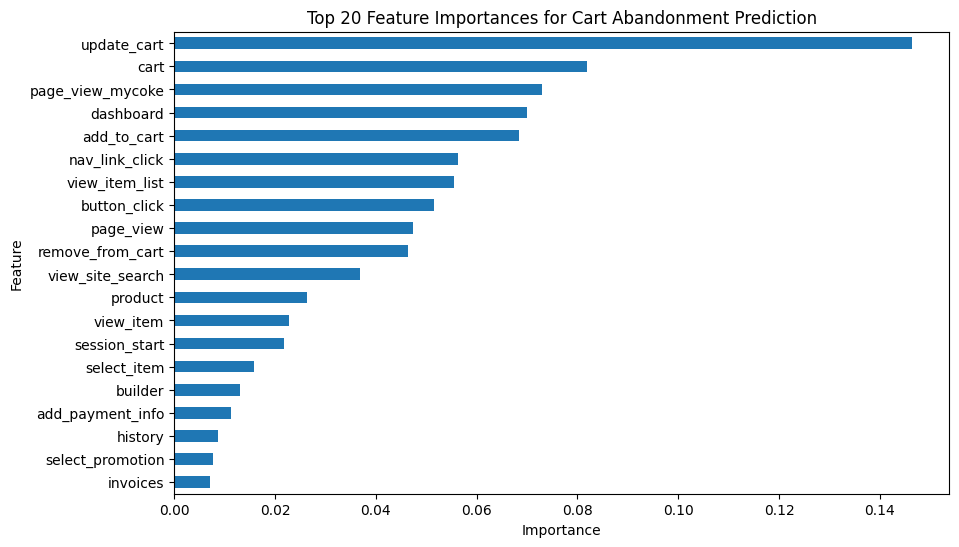

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd

# filter out rows where nothing was added to cart
behavior_with_labels = behavior_with_labels[behavior_with_labels['had_add'] == 1]

# Separate features (X) and target variable (y)
# Exclude the identifier columns and the recovery column for abandonment prediction
X = behavior_with_labels.drop(columns=['CUSTOMER_ID', 'window_start', 'window_end', 'Abandoned', 'Recovered_before_next_window_end'])
y = behavior_with_labels['Abandoned']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Initialize and train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced') # Using balanced class_weight to handle potential imbalance
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Predict probabilities for AUC calculation
y_pred_proba = model.predict_proba(X_test)[:, 1] # Get probabilities for the positive class (Abandoned=1)


# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba) # Calculate AUC-ROC


print("Model Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC Score: {auc_roc:.4f}") # Print AUC-ROC


# Display a detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot Feature Importance
# Get feature importances
feature_importances = pd.Series(model.feature_importances_, index=X.columns)

# Sort feature importances and take the top N
top_n = 20 # Display top 20 features
top_features = feature_importances.nlargest(top_n)

plt.figure(figsize=(10, 6))
top_features.plot(kind='barh')
plt.title(f'Top {top_n} Feature Importances for Cart Abandonment Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis() # Invert y-axis to show the most important feature at the top
plt.show()

Wow! This model perfomed great on out-of-sample data! With high precision, the model is great at avoiding false positives (predicting cart abandonment when it didn't happen). However, the moderate recall indicates that the model is missing about half the actual abandoned carts. If identifying as many abandoned carts as possible is a priority (even at the risk of some false positives), we might want to adjust the model's decision threshold. With a high AUC-ROC, the model has strong discriminatory power overall, so adjusting the decision threshold would be advantagous if this model gets deployed.

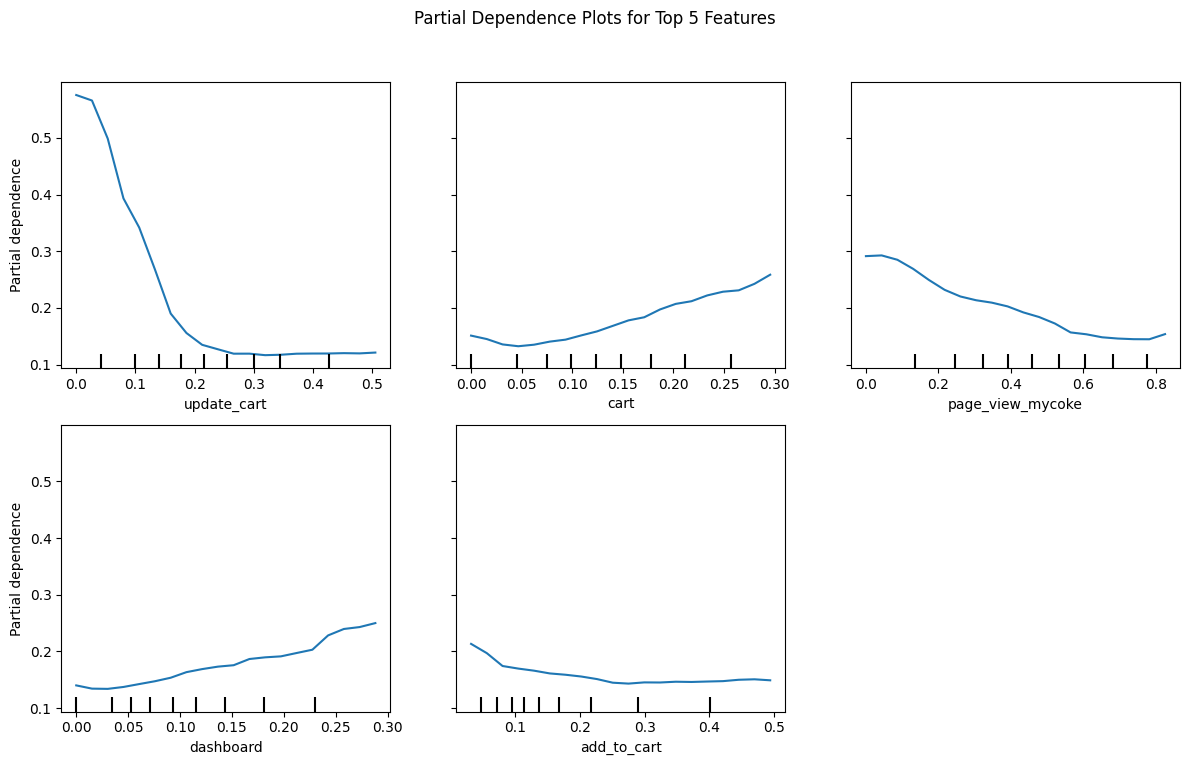

In [64]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'model' is your trained RandomForestClassifier and
# 'X_test' and 'y_test' are your test sets from the previous cell (bXnlxCVZVfKr)
# and 'feature_importances' is the Series of feature importances

# Get the names of the top 5 most important features
top_5_features = feature_importances.nlargest(5).index.tolist()

# Create Partial Dependence Plots
# We need to specify the features to plot and the model and data
# The target_names are optional but can make the plot clearer
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    model,
    X_test,
    top_5_features,
    # Removed target_names as it's not supported in this version
    n_jobs=3, # Use multiple cores if available
    grid_resolution=20, # Number of points to evaluate on the feature axis
    ax=ax
)
plt.suptitle('Partial Dependence Plots for Top 5 Features')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

These plots show the partial dependence for the top 5 features in the model. Most notably, order windows with less or no update_cart events are associated with higher cart abandonment.

### Predicting Cart Recovery

Model Performance Metrics (Predicting Cart Recovery):
Accuracy: 0.5769
Precision: 0.5504
Recall: 0.5262
F1 Score: 0.5381
AUC-ROC Score: 0.6131

Classification Report (Predicting Cart Recovery):
              precision    recall  f1-score   support

         0.0       0.60      0.62      0.61       671
         1.0       0.55      0.53      0.54       591

    accuracy                           0.58      1262
   macro avg       0.57      0.57      0.57      1262
weighted avg       0.58      0.58      0.58      1262



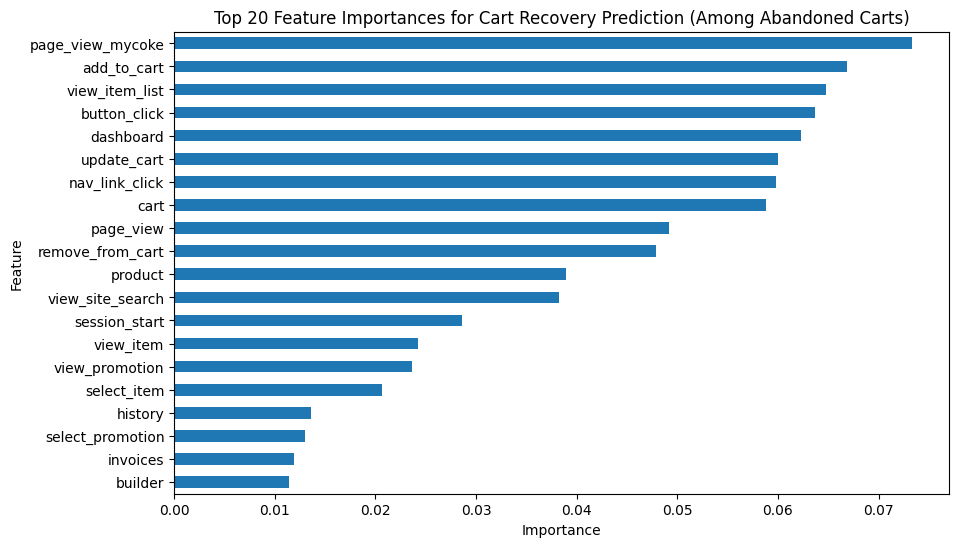

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd

# Filter the dataset for abandoned carts
abandoned_carts_df = behavior_with_labels[behavior_with_labels['Abandoned'] == 1].copy()

# Separate features (X) and target variable (y) for recovery prediction
# Exclude identifier columns, the 'Abandoned' column, and the 'time_to_recovery_days' column
X_recovery = abandoned_carts_df.drop(columns=['CUSTOMER_ID', 'window_start', 'window_end', 'Abandoned', 'Recovered_before_next_window_end', 'order_ts', 'time_to_recovery_days'], errors='ignore')
y_recovery = abandoned_carts_df['Recovered_before_next_window_end']

# Split data into training and testing sets
X_train_recovery, X_test_recovery, y_train_recovery, y_test_recovery = train_test_split(X_recovery, y_recovery, test_size=0.25, random_state=42, stratify=y_recovery)

# Initialize and train a Random Forest Classifier for recovery prediction
model_recovery = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced') # Using balanced class_weight to handle potential imbalance
model_recovery.fit(X_train_recovery, y_train_recovery)

# Predict on the test set
y_pred_recovery = model_recovery.predict(X_test_recovery)

# Predict probabilities for AUC calculation
y_pred_proba_recovery = model_recovery.predict_proba(X_test_recovery)[:, 1] # Get probabilities for the positive class (Recovered=1)


# Evaluate model performance
accuracy_recovery = accuracy_score(y_test_recovery, y_pred_recovery)
precision_recovery = precision_score(y_test_recovery, y_pred_recovery)
recall_recovery = recall_score(y_test_recovery, y_pred_recovery)
f1_recovery = f1_score(y_test_recovery, y_pred_recovery)
auc_roc_recovery = roc_auc_score(y_test_recovery, y_pred_proba_recovery) # Calculate AUC-ROC


print("Model Performance Metrics (Predicting Cart Recovery):")
print(f"Accuracy: {accuracy_recovery:.4f}")
print(f"Precision: {precision_recovery:.4f}")
print(f"Recall: {recall_recovery:.4f}")
print(f"F1 Score: {f1_recovery:.4f}")
print(f"AUC-ROC Score: {auc_roc_recovery:.4f}") # Print AUC-ROC


# Display a detailed classification report
print("\nClassification Report (Predicting Cart Recovery):")
print(classification_report(y_test_recovery, y_pred_recovery))

# Plot Feature Importance
# Get feature importances
feature_importances_recovery = pd.Series(model_recovery.feature_importances_, index=X_recovery.columns)

# Sort feature importances and take the top N
top_n_recovery = 20 # Display top 20 features
top_features_recovery = feature_importances_recovery.nlargest(top_n_recovery)

plt.figure(figsize=(10, 6))
top_features_recovery.plot(kind='barh')
plt.title(f'Top {top_n_recovery} Feature Importances for Cart Recovery Prediction (Among Abandoned Carts)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis() # Invert y-axis to show the most important feature at the top
plt.show()

This model performed much more poorly, and is barely better than just randomly guessing whether carts will be recovered. Because of this, the rest of our behavioral analysis will focus on cart abandonment.

### Gaining A Deeper understanding of abandoned carts

Now, we will use clustering techniques to better understand what behaviors precede cart abandonment.

In [66]:
from sklearn.decomposition import TruncatedSVD

# Step 1: Filter for abandoned carts
abandoned_tfidf = behavior_with_labels[behavior_with_labels['Abandoned'] == 1].copy()

# Step 2: Select features for LSA
# Exclude the identifier and label columns
feature_cols = [col for col in abandoned_tfidf.columns if col not in ['CUSTOMER_ID', 'window_start', 'window_end', 'Abandoned', 'Recovered_before_next_window_end', 'order_ts', 'time_to_recovery_days', 'had_add']]
X_abandoned = abandoned_tfidf[feature_cols]

# Initialize TruncatedSVD (LSA).
n_components = 5 # Reduced the number of components for easier interpretation and clustering
lsa = TruncatedSVD(n_components=n_components, random_state=42)

# Fit and transform the feature matrix
X_lsa = lsa.fit_transform(X_abandoned)

# Create a DataFrame from the LSA components
lsa_components_df = pd.DataFrame(X_lsa, index=abandoned_tfidf.index,
                                 columns=[f'lsa_{i+1}' for i in range(n_components)])

# Add the window identifiers back to the LSA components DataFrame
lsa_components_df[['CUSTOMER_ID', 'window_start', 'window_end']] = abandoned_tfidf[['CUSTOMER_ID', 'window_start', 'window_end']]


# Display the resulting LSA components DataFrame
display(lsa_components_df.head())

# You can now proceed with clustering using lsa_components_df

,lsa_1,lsa_2,lsa_3,lsa_4,lsa_5,CUSTOMER_ID,window_start,window_end
46,0.895809,0.263810,0.029059,-0.049772,0.051245,500245738,2024-11-08 21:30:00+00:00,2024-11-15 21:30:00+00:00
47,0.895809,0.263810,0.029059,-0.049772,0.051245,500245738,2024-11-08 23:00:00+00:00,2024-11-15 23:00:00+00:00
77,0.625595,0.651308,0.057523,-0.189538,0.146226,500245738,2025-01-30 00:00:00+00:00,2025-02-06 00:00:00+00:00
78,0.625595,0.651308,0.057523,-0.189538,0.146226,500245738,2025-01-31 21:30:00+00:00,2025-02-07 21:30:00+00:00
79,0.625595,0.651308,0.057523,-0.189538,0.146226,500245738,2025-01-31 23:00:00+00:00,2025-02-07 23:00:00+00:00


In [67]:
# Get the original feature names
feature_names = X_abandoned.columns

# Get the LSA components (the relationship between components and original features)
lsa_components = lsa.components_

# Number of top features to display for each component
n_top_features = 10

print("Top features for each LSA component:")

# Iterate through all LSA components
for i, component in enumerate(lsa_components):
    # Sort the feature weights for the current component
    # Use argsort to get the indices of the sorted weights
    top_positive_indices = component.argsort()[-n_top_features:][::-1]

    print(f"\nComponent {i+1}:")

    print("  Most positive features:")
    for idx in top_positive_indices:
        print(f"    {feature_names[idx]} ({component[idx]:.4f})")

Top features for each LSA component:

Component 1:
  Most positive features:
    page_view_mycoke (0.5409)
    view_item_list (0.5279)
    button_click (0.4580)
    update_cart (0.2067)
    add_to_cart (0.2007)
    dashboard (0.1751)
    cart (0.1706)
    page_view (0.1490)
    view_site_search (0.1361)
    remove_from_cart (0.0979)

Component 2:
  Most positive features:
    page_view_mycoke (0.6529)
    dashboard (0.2325)
    update_cart (0.1582)
    cart (0.1468)
    nav_link_click (0.0872)
    page_view (0.0478)
    invoices (0.0356)
    support (0.0249)
    history (0.0216)
    pay_invoice_click (0.0207)

Component 3:
  Most positive features:
    user_engagement (0.6401)
    screen_view (0.5665)
    select_item (0.1852)
    productslist_plp_retrieved (0.1815)
    productcount_plp (0.1815)
    categories_plp_retrieved (0.1522)
    updatecart_cart_clicked (0.1269)
    updatecart_cart_retrieved (0.1247)
    productaddtocart_plp_clicked (0.1233)
    view_search_results (0.0984)

Comp

The LSA analysis has identified several underlying patterns (components) in the sequence of events leading up to an abandoned cart. Each component is characterized by a set of events that tend to occur together. The "most positive features" for each component are the events that are most strongly associated with that component.

Here's an interpretation of the components based on the top features:

- Component 1: This component seems to represent a general browsing and shopping behavior pattern. The high weights on 'page_view_mycoke', 'view_item_list', 'button_click', 'update_cart', and 'add_to_cart' suggest customers in this group are actively navigating the site, viewing product lists, clicking buttons, and adding items to their cart. The presence of 'remove_from_cart' might indicate some indecision or refinement of their cart before abandoning.
- Component 2: This component appears to be related to users who are primarily interacting with their account or dashboard. The top features like 'page_view_mycoke', 'dashboard', 'update_cart', and 'cart' suggest users are checking their dashboard, possibly managing their cart, and navigating within the site. The inclusion of 'nav_link_click', 'invoices', 'support', and 'history' could indicate they are also looking at past orders, invoices, or seeking support before abandoning.
- Component 3: This component seems to capture user engagement and product viewing activities. High weights on 'user_engagement', 'screen_view', 'select_item', 'productslist_plp_retrieved', and 'categories_plp_retrieved' suggest users are actively viewing screens, selecting items, and retrieving product lists and categories. 'updatecart_cart_clicked' and 'updatecart_cart_retrieved' indicate interaction with the cart update process, while 'productaddtocart_plp_clicked' and 'view_search_results' show product adding from product lists and searching.
- Component 4: This component is strongly dominated by 'button_click'. Features like 'builder', 'product', 'page_view', 'history', 'support', and 'account' with smaller weights suggest users are clicking buttons across various parts of the site, potentially related to account management, viewing order history, or seeking support.
- Component 5: This component highlights direct cart manipulation and searching. The top features 'update_cart', 'view_site_search', 'remove_from_cart', and 'add_to_cart' indicate users are actively updating their cart, searching the site, adding, and removing items. This could suggest users are refining their cart contents or looking for specific items before abandoning.

In [68]:
from sklearn.cluster import KMeans

# Separate the LSA components from the identifier columns
X_lsa_features = lsa_components_df.drop(columns=['CUSTOMER_ID', 'window_start', 'window_end'])

# Initialize and run K-Means clustering with K=4
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # explicitly set n_init
kmeans.fit(X_lsa_features)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Add the cluster labels to the abandoned_tfidf DataFrame
# Ensure the index of cluster_labels aligns with the index of abandoned_tfidf
abandoned_tfidf['cluster_label'] = cluster_labels

# Display the head of the DataFrame with cluster labels
display(abandoned_tfidf.head())

,CUSTOMER_ID,window_start,window_end,about,account,account_pressed_failed,accounts,accountselect_switchaccount_clicked,accountselect_switchaccount_completed,add_payment_info,...,view_cart,view_item,view_item_list,view_promotion,view_search_results,view_site_search,had_add,Abandoned,Recovered_before_next_window_end,cluster_label
46,500245738,2024-11-08 21:30:00+00:00,2024-11-15 21:30:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.060414,0.317441,0.0,0.0,0.093809,1.0,1.0,0.0,3
47,500245738,2024-11-08 23:00:00+00:00,2024-11-15 23:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.060414,0.317441,0.0,0.0,0.093809,1.0,1.0,1.0,3
77,500245738,2025-01-30 00:00:00+00:00,2025-02-06 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.0,1.0,0.0,3
78,500245738,2025-01-31 21:30:00+00:00,2025-02-07 21:30:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.0,1.0,0.0,3
79,500245738,2025-01-31 23:00:00+00:00,2025-02-07 23:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.0,1.0,1.0,3


In [69]:
# Analyze the characteristics of each cluster
# Group by cluster label and calculate the mean of the TF-IDF features
cluster_characteristics = abandoned_tfidf.groupby('cluster_label').mean()

# Drop non-feature columns before calculating mean for feature analysis
feature_cols = [col for col in abandoned_tfidf.columns if col not in ['CUSTOMER_ID', 'window_start', 'window_end', 'Abandoned', 'Recovered_before_next_window_end', 'order_ts', 'time_to_recovery_days', 'had_add', 'cluster_label']]
cluster_characteristics = abandoned_tfidf.groupby('cluster_label')[feature_cols].mean()


# Identify the top N features for each cluster
n_top_features = 10 # Number of top features to display per cluster

print("Top features for each cluster:")
for cluster_label in range(k): # Iterate through each cluster
    print(f"\nCluster {cluster_label}:")
    # Get the mean TF-IDF scores for the current cluster, sort and get top N
    top_features_cluster = cluster_characteristics.loc[cluster_label].sort_values(ascending=False).head(n_top_features)
    for feature, score in top_features_cluster.items():
        print(f"  {feature} ({score:.4f})")

Top features for each cluster:

Cluster 0:
  user_engagement (0.5012)
  screen_view (0.4426)
  productslist_plp_retrieved (0.1582)
  productcount_plp (0.1582)
  select_item (0.1545)
  categories_plp_retrieved (0.1300)
  updatecart_cart_clicked (0.1123)
  productaddtocart_plp_clicked (0.1111)
  updatecart_cart_retrieved (0.1104)
  view_search_results (0.0837)

Cluster 1:
  button_click (0.6062)
  page_view_mycoke (0.3661)
  view_item_list (0.3492)
  page_view (0.1287)
  update_cart (0.1261)
  dashboard (0.1226)
  add_to_cart (0.1059)
  product (0.0997)
  cart (0.0976)
  view_site_search (0.0836)

Cluster 2:
  view_item_list (0.6065)
  button_click (0.3629)
  page_view_mycoke (0.3094)
  add_to_cart (0.2393)
  view_site_search (0.1930)
  update_cart (0.1460)
  cart (0.1185)
  page_view (0.1129)
  dashboard (0.0964)
  remove_from_cart (0.0914)

Cluster 3:
  page_view_mycoke (0.6240)
  view_item_list (0.2839)
  button_click (0.2557)
  update_cart (0.2174)
  dashboard (0.2048)
  cart (0.1807

### Cluster Analysis Summary and Business Recommendations

Based on the top features in each cluster, here's a summary of the potential customer groups and business recommendations for each:

#### Cluster 0: Engaged Explorers with Specific Interests

*   **Summary:** This cluster is characterized by high engagement and focused exploration of products. The top features indicate users are actively viewing screens, engaging with the app, selecting items, and retrieving product lists and categories. They are also interacting with the cart update process and using search.
*   **Potential Customer Group:** These could be customers who are actively researching specific products or categories. They are highly engaged but might be encountering issues with product details, availability, or finding exactly what they need, leading to abandonment.
*   **Business Recommendation:**
    *   **Enhance Product Information:** Ensure detailed and accurate product descriptions, images, and specifications are easily accessible.
    *   **Improve Search Functionality:** Optimize search results and filtering options to help users find desired products quickly.
    *   **Provide In-Stock Notifications:** If abandonment is due to stock issues, allow users to sign up for notifications when items are back in stock.
    *   **Offer Live Chat Support:** Provide immediate assistance for product-related questions or issues encountered during browsing.

#### Cluster 1: Broad Browsers and Dashboard Users

*   **Summary:** This cluster shows a mix of broad browsing and interaction with the dashboard. Top features include general button clicks, page views on "MyCoke", viewing item lists, and interacting with the cart and update cart functions.
*   **Potential Customer Group:** This group might include customers who are browsing widely, possibly comparing products or just exploring the site. Their interaction with the dashboard could indicate they are also managing their account or checking order history, but they abandon the cart during their browsing session.
*   **Business Recommendation:**
    *   **Streamline Navigation:** Simplify site navigation and product categorization to make browsing easier and more efficient.
    *   **Personalize Recommendations:** Offer personalized product recommendations based on their browsing history or past orders.
    *   **Highlight Promotions:** Clearly display relevant promotions or discounts to incentivize completing the purchase.
    *   **Simplify the Cart Process:** Ensure the cart and checkout process is straightforward and free of unexpected steps or costs.

#### Cluster 2: Item List Viewers and Cart Manipulators

*   **Summary:** This cluster is strongly associated with viewing item lists, button clicks, adding and removing items from the cart, and using site search.
*   **Potential Customer Group:** These customers are likely focused on building and refining their cart. The frequent adding and removing of items, combined with searching, suggests they might be price comparing, looking for alternatives, or facing issues with item quantities or variations.
*   **Business Recommendation:**
    *   **Optimize Cart Functionality:** Make it easy to update quantities, remove items, and see the updated total.
    *   **Provide Clear Pricing and Availability:** Ensure pricing and stock information are transparent and updated in real-time.
    *   **Offer Flexible Cart Management:** Allow users to save carts for later or easily switch between different cart options.
    *   **Address Potential Friction Points:** Identify and resolve any technical issues or confusing steps in the cart or checkout process.

#### Cluster 3: Dashboard-Centric Browsers and Updaters

*   **Summary:** This cluster is characterized by significant interaction with the "MyCoke" dashboard, viewing item lists, button clicks, and using the update cart function. They also show interactions with navigation links and product pages.
*   **Potential Customer Group:** This group might consist of returning customers who primarily use the dashboard to manage their account and place orders. They are familiar with the site but might be encountering issues related to account management, order history, or the process of updating their cart from a previous order or list.
*   **Business Recommendation:**
    *   **Enhance Dashboard Usability:** Improve the design and functionality of the dashboard for easier order management and reordering.
    *   **Simplify Reordering:** Make it simple for customers to reorder past purchases or add items from their order history to the current cart.
    *   **Provide Proactive Support:** Offer assistance or tutorials for dashboard features and the ordering process.
    *   **Gather Feedback:** Collect feedback from these users about their experience with the dashboard and ordering process to identify areas for improvement.

By understanding these distinct behavioral patterns, Swire can develop targeted strategies and interventions to address the specific reasons behind cart abandonment for each customer segment, ultimately improving cart abandonment.

# Group Contributions

- Amber Cash

    - Abandoned and recovered cart definition

- Radhika Bhakta

    - Understanding Abandonment and Recovery in Relation to Cutoff Windows
    - Logistic Regression

- Spencer Brothers

    - Mapping dictionaries
    - `visit_plan` pre-processing
    - Text analytics approach for abandoned
    
- Tami Salvador

    - Added bar charts for Estimated Financial Loss from Abandoned Carts by Brand and by Pack Type
    - Reviewing and formatting the notebook
